<a href="https://colab.research.google.com/github/rania13-Ssudo/TFM-Short-term-forecasting-of-electricity-consumption-using-advanced-time-series-techniques/blob/main/TFM_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Short-term Forecasting Of Electricity Consumption Using Advanced Time-Series Techniques**


## **Project and dataset explanations:**

Time series forecasting predicts future values based on historical data. This work presents a comparative study of  time series forecasting algorithms
evaluated using a real-time electricity consumption dataset collected from hotel in Spain over the period from February 2021 to March 2025, with the goal of accurately predicting energy consumption for the
upcoming 24 hours.

## **Methods used in this project:**


### **1. Classical Models:**

*   SARIMA.

### **2. Machine Learning Models:**


*   Ridge Regression.
*   XGBoost Regressor.
*   Random Forest.
*   Support Vector Regression (SVR).




### **3. Deep Learning Models:**


*   CNN (Convolutional Neural Networks).

*   GRU (Gated Recurrent Units).
*   LSTM (Long Short-Term Memory).


*   TCN (Temporal Convolutional Networks).




# **Installing and importing Required Libraries**
In order to run this project, it's necessary to install the  following required libraries.
The libraries are installed using the pip package manager as shown below.

In [1]:
!pip install xgboost scikeras tensorflow --quiet
!pip install scikeras
!pip install keras-tcn
!pip install tensorflow
!pip install skforecast


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.4/851.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.2 MB/s eta 0:00:00


# **Importing Modules and Libraries**


This following libraries are imported to handle the data processing, modeling, training, evaluation, and the visualisation of this project.

In [2]:
import time
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.plot import calculate_lag_autocorrelation
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from scikeras.wrappers import KerasRegressor
from tcn import TCN
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Conv1D, MaxPooling1D, Flatten, Input, LayerNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import random
import time
import warnings
warnings.filterwarnings('ignore')
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster,
    backtesting_sarimax,
)



# **Experiment Setup**

In this section, we define the main configuration parameters for our forecasting experiment.
These parameters specify the dataset location, the training/Validation splits, the forecasting horizon `steps`, and the number of lagged observations used as input.
A random seed was fixed to ensure reproducibility.

In [3]:
data_dir="./data"
results_dir="./results"
dataset_name="4datos_preprocesados_mayo21-febrero25"
train_ends="2023-12-31 23:59:00"
val_ends="2024-12-31 23:59:00"
seed=0
steps=24 # 24 data to predict
lags=168 # 168 data to be used prior to prediction
n_jobs=-1

# **Data**

First step is  to load our training dataset from a CSV file into a Pandas DataFrame.

In [4]:
df = pd.read_csv(
    "/content/4datos_preprocesados_mayo21-febrero25.csv",
    sep=",",
    decimal=".",
)


Then, creating the output directory and save the preprocessed dataset as a CVS file. It will be stored in the defined `data_dir` with the corresponding dataset name.

In [5]:

os.makedirs(data_dir, exist_ok=True)

df.to_csv(
    f"{data_dir}/{dataset_name}_processed.csv",
    index=True,
    sep=",",
    decimal="."
)


The dataset contains the following columns :

- **Fecha**: Date of the observation.  
- **Hora**: Hour of the observation.  
- **AE**: Energy consumption (KWH).  

In [6]:
print(df.columns)
df.head(10)


Index(['Fecha', 'Hora', 'AE'], dtype='object')


Fecha   Hora   AE
0  01/05/2021  00:00   37
1  01/05/2021  01:00   28
2  01/05/2021  02:00   28
3  01/05/2021  03:00   33
4  01/05/2021  04:00   34
5  01/05/2021  05:00   36
6  01/05/2021  06:00   34
7  01/05/2021  07:00   31
8  01/05/2021  08:00   32
9  01/05/2021  09:00  115

# **Data Preprocessing**

Now, We begin by combining the `Fecha` and `Hora` columns into a single timestamp, which is then used as a `datetime` index of teh dataset.

After, the `Hora` column is removed, duplicate rows are deleted, and the index is sorted by date and time.

The series are resampled to an hourly frequency to make sure all timestamps are aligned. Next, two checks are performed : the dataset has no missing values and that the time index is complete ( `i.e` fully covers the observation period without interruptions).

The dataset is saved as a processed CSV file. Finally the data is split into training, validation and test sets using the predefined cut-off dates (`train_ends` and `val_ends`).




In [7]:

df["Fecha"] = pd.to_datetime(
    df["Fecha"] + " " + df["Hora"], format="%d/%m/%Y %H:%M"
)
df.drop(columns=["Hora"], inplace=True)
df.set_index("Fecha", inplace=True)
df = df.sort_index()
# get duplicate indexes
df = df[~df.index.duplicated(keep="first")]

df = df.asfreq("h")
# Check that there is no lost data
assert df.isnull().any(axis=1).mean() == 0.0, "Data contains missing values"
print(f"Complete data: {df.isnull().any(axis=1).mean() == 0.0}")

# Verify that the temporary index is complete
fecha_inicio = df.index.min()
fecha_fin = df.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq="1h")
assert (df.index == date_range_completo).all(), "Data index is not complete"
print(f"Full index: {(df.index == date_range_completo).all()}")

# save data into file
df.to_csv(
    f"{data_dir}/{dataset_name}_processed.csv", index=True, sep=",", decimal="."
)

# Train-test data separation
datos = df.copy()

datos_train = datos.loc[:train_ends, :].copy()
datos_val = datos.loc[train_ends:val_ends, :].copy()
datos_test = datos.loc[val_ends:, :].copy()

Complete data: True
Full index: True


# **Dataset Overview**


To better understand the structure of the dataset, we are going to display some informations about:

The list of the columns after the preporecssing.

In [8]:
print(df.columns)

Index(['AE'], dtype='object')


The first and last 10 rows are shown to see the time format.

In [9]:

print("First 10 rows of the dataset.","\n")
df.head(10)

First 10 rows of the dataset. 



AE
Fecha                   
2021-05-01 00:00:00   37
2021-05-01 01:00:00   28
2021-05-01 02:00:00   28
2021-05-01 03:00:00   33
2021-05-01 04:00:00   34
2021-05-01 05:00:00   36
2021-05-01 06:00:00   34
2021-05-01 07:00:00   31
2021-05-01 08:00:00   32
2021-05-01 09:00:00  115

In [10]:
print("Last 10 rows of the dataset.","\n")
df.tail(10)

Last 10 rows of the dataset. 



AE
Fecha                   
2025-02-28 14:00:00   41
2025-02-28 15:00:00   33
2025-02-28 16:00:00   87
2025-02-28 17:00:00  129
2025-02-28 18:00:00  154
2025-02-28 19:00:00  127
2025-02-28 20:00:00  123
2025-02-28 21:00:00   79
2025-02-28 22:00:00   77
2025-02-28 23:00:00   53

A statistical summary of the numerical variables (AE), obtained with `df.describe()`.  

In [11]:
df.describe()

AE
count  33600.000000
mean      94.929851
std       58.772403
min        0.000000
25%       50.000000
50%       79.000000
75%      127.000000
max      426.000000

to get an idea of the training, validation, and test sets, the date ranges and number of samples in are shown

In [12]:
print(
    f"Train dates      : {datos_train.index.min()} --- {datos_train.index.max()}"
    + f" (n={len(datos_train)})"
)
print(
    f"Validation dates : {datos_val.index.min()} --- {datos_val.index.max()}"
    + f" (n={len(datos_val)})"
)
print(
    f"test dates      : {datos_test.index.min()} --- {datos_test.index.max()}"
    + f" (n={len(datos_test)})"
)


Train dates      : 2021-05-01 00:00:00 --- 2023-12-31 23:00:00 (n=23400)
Validation dates : 2024-01-01 00:00:00 --- 2024-12-31 23:00:00 (n=8784)
test dates      : 2025-01-01 00:00:00 --- 2025-02-28 23:00:00 (n=1416)


# **visualization**

In this section, we use create visualisations to explore and better understand  the dataset using `go` from `plotly.graph_objects`.

### **Hourly consumption**

To provide a clear overview of the temporal coverage and observe the overall evolution of the series, this plot displays in the form of lines the hourly electricity consumption, divided into training, validation, and test sets.  

In [13]:


if not os.path.exists(f"{data_dir}/graphics"):
    os.makedirs(f"{data_dir}/graphics")
# We show a graph with all the consumption
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=datos_train.index, y=datos_train["AE"], mode="lines", name="Train"
    )
)
fig.add_trace(
    go.Scatter(
        x=datos_val.index, y=datos_val["AE"], mode="lines", name="Validation"
    )
)
fig.add_trace(
    go.Scatter(
        x=datos_test.index, y=datos_test["AE"], mode="lines", name="Test"
    )
)
fig.update_layout(
    title="Hourly consumption",
    xaxis_title="DATE",
    yaxis_title="Consumption (kWh)",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001),
)

### **Monthly Electricity Consumption**

The energy consumption is resampled monthly and shown with lines and markers for the training, validation, and test sets, to make it easy to observe verall trends and seasonal changes across months.

In [ ]:

train_monthly = datos_train["AE"].resample("M").sum()
val_monthly   = datos_val["AE"].resample("M").sum()
test_monthly  = datos_test["AE"].resample("M").sum()

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_monthly.index, y=train_monthly, mode="lines+markers", name="Train")
)
fig.add_trace(
    go.Scatter(x=val_monthly.index, y=val_monthly, mode="lines+markers", name="Validation")
)
fig.add_trace(
    go.Scatter(x=test_monthly.index, y=test_monthly, mode="lines+markers", name="Test")
)

fig.update_layout(
    title="Monthly Electricity Consumption",
    xaxis_title="Date",
    yaxis_title="Consumption (kWh)",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001),
    template="plotly_white"
)

fig.show()


### **Zoom on a Specific Period**

A zoomed view of `May 2022 `is provided to better observe short-term variations in consumption.  
This help us to observe small patterns that are harder to see in the full series.

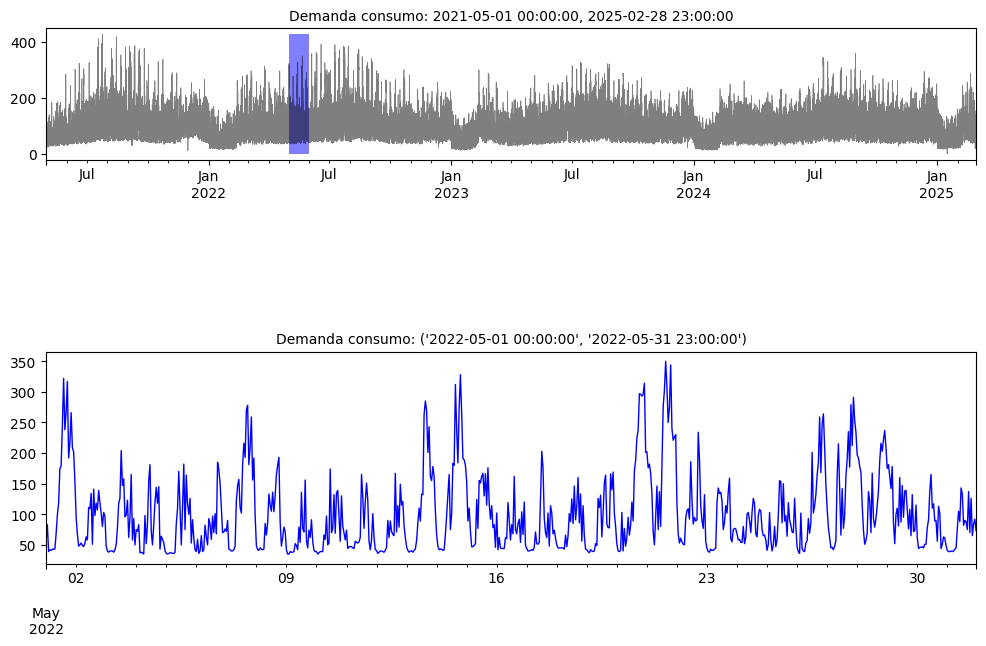

In [ ]:
zoom = ("2022-05-01 00:00:00", "2022-05-31 23:00:00")
fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
datos.AE.plot(ax=main_ax, c="black", alpha=0.5, linewidth=0.5)
min_y = min(datos.AE)
max_y = max(datos.AE)
main_ax.fill_between(zoom, min_y, max_y, facecolor="blue", alpha=0.5, zorder=0)
main_ax.set_xlabel("")
datos.loc[zoom[0] : zoom[1]].AE.plot(  # noqa
    ax=zoom_ax, color="blue", linewidth=1
)
main_ax.set_title(
    f"Demanda consumo: {datos.index.min()}, {datos.index.max()}", fontsize=10
)
zoom_ax.set_title(f"Demanda consumo: {zoom}", fontsize=10)
zoom_ax.set_xlabel("")
plt.subplots_adjust(hspace=1)

plt.show()

### **Seasonality Patterns**

Now, we use `matplotlib` to explore the electricity consumption through boxplots combined with median trend lines.
This format allows us to visualize the distribution  of consumption across different time scales, making it easier to examine patterns and variations over the year, week, and day.


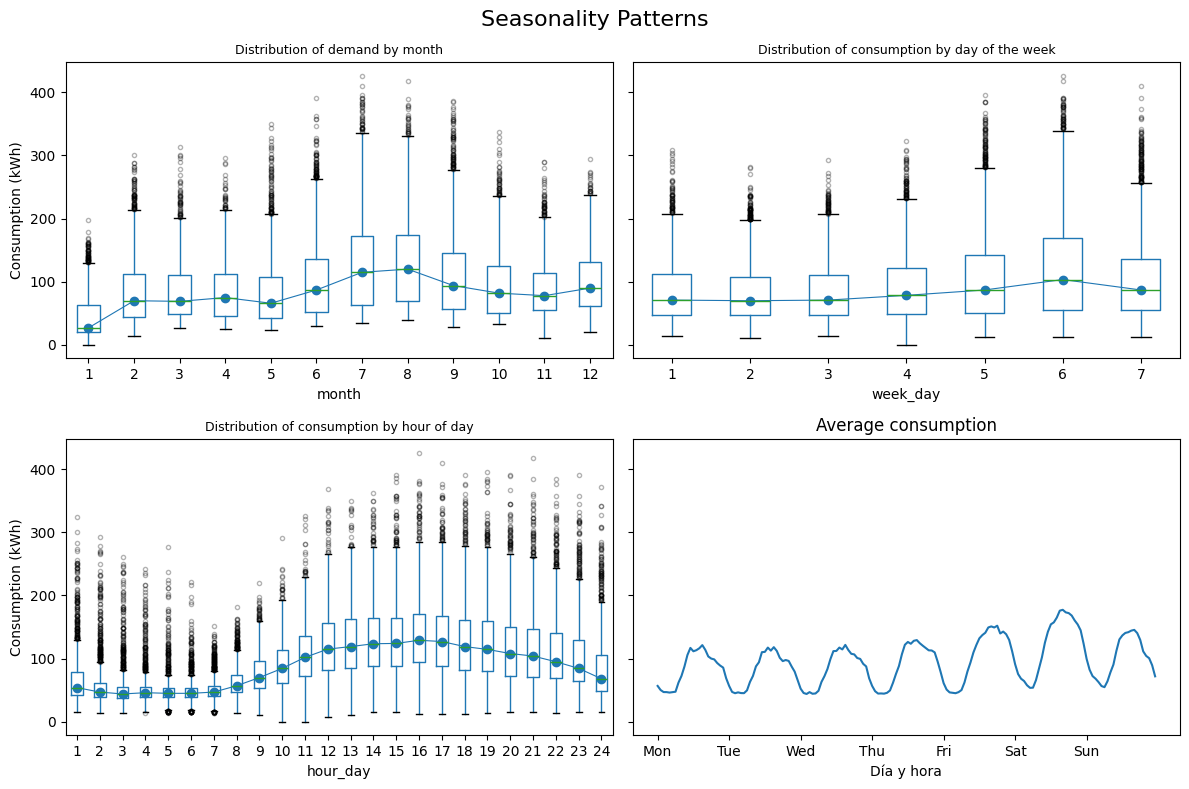

In [17]:
# Annual, weekly and daily seasonality
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
axs = axs.ravel()

# Distribution of demand by month
datos["month"] = datos.index.month
datos.boxplot(
    column="AE",
    by="month",
    ax=axs[0],
    flierprops={"markersize": 3, "alpha": 0.3},
)
datos.groupby("month")["AE"].median().plot(style="o-", linewidth=0.8, ax=axs[0])
axs[0].set_ylabel("Consumption (kWh)")
axs[0].set_title("Distribution of demand by month", fontsize=9)

# Distribution of consumption by day of the week
datos["week_day"] = datos.index.day_of_week + 1
datos.boxplot(
    column="AE",
    by="week_day",
    ax=axs[1],
    flierprops={"markersize": 3, "alpha": 0.3},
)
datos.groupby("week_day")["AE"].median().plot(
    style="o-", linewidth=0.8, ax=axs[1]
)
axs[1].set_ylabel("AE")
axs[1].set_title("Distribution of consumption by day of the week", fontsize=9)

# Distribution of consumption by hour of day
datos["hour_day"] = datos.index.hour + 1
datos.boxplot(
    column="AE",
    by="hour_day",
    ax=axs[2],
    flierprops={"markersize": 3, "alpha": 0.3},
)
datos.groupby("hour_day")["AE"].median().plot(
    style="o-", linewidth=0.8, ax=axs[2]
)
axs[2].set_ylabel("Consumption (kWh)")
axs[2].set_title("Distribution of consumption by hour of day", fontsize=9)

# Distribution of consumption by day of the week and time of day
mean_day_hour = datos.groupby(["week_day", "hour_day"])["AE"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title="Average consumption",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Día y hora",
    ylabel="Consumption (kWh)",
)
axs[3].title.set_size(12)

fig.suptitle("Seasonality Patterns", fontsize=16)
fig.tight_layout()

plt.show()

# **Checking For stationarity- Dickey-Fuller (ADF)**

*  **The Dickey-Fuller** test , also known as **the Augmented Dickey-Fuller (ADF)** test, is a statistical test used to determine whether a time series is stationary or not. **Stationarity** is an important concept in time series analysis because it affects the ability to model and predict future values. The test uses a null hypothesis that the time series has a unit root, meaning that it is non-stationary. The alternative hypothesis is that the time series is stationary. The test statistic is compared to critical values from tables or computed via a statistical software package. If the test statistic is less than the critical value, the null hypothesis is rejected, and it is concluded that the time series is stationary.

*  In the context of time series analysis, stationarity refers to a property of a time series where the statistical properties of the series do not change over time . More specifically, a stationary time series is one where the mean, variance, and autocorrelation structure of the series do not depend on the time at which they are computed.

In [ ]:

def test_stationarity(series, name="Series"):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("series is not stationary")


series = df["AE"]

print("Test on the raw series:")
test_stationarity(series)

print("\nTest on the differenced series:")
test_stationarity(series.diff().dropna())


Test on the raw series:
ADF Statistic: -14.626356640883287
p-value: 3.813317770137407e-27
Critical Value (1%): -3.4305449444195664
Critical Value (5%): -2.8616261604986013
Critical Value (10%): -2.566815860545899
Series is stationary

Test on the differenced series:
ADF Statistic: -33.71511754577297
p-value: 0.0
Critical Value (1%): -3.4305449444195664
Critical Value (5%): -2.8616261604986013
Critical Value (10%): -2.566815860545899
Series is stationary


# **Additive Seasonal Decomposition**

To make things clearer, we can use the `seasonal_decompose` method, which decomposes the series into its `seasonal`, `trend`, and `residual` components.

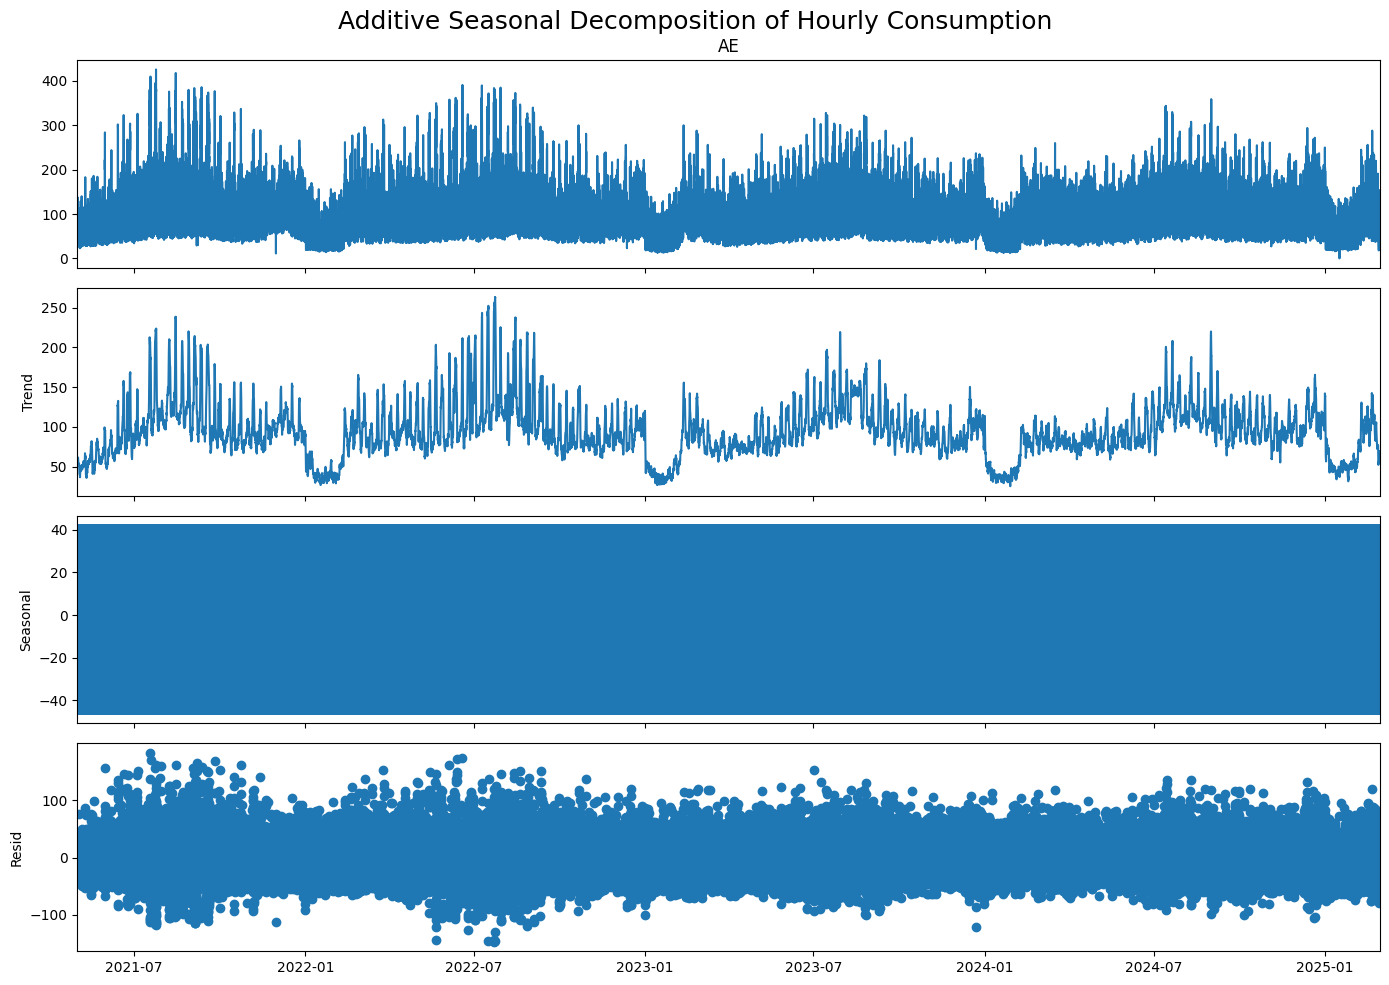

In [ ]:
series = df['AE']

result = seasonal_decompose(series, model='additive', period=24)

fig = result.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Additive Seasonal Decomposition of Hourly Consumption", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


# **Autocorrelation and Partial Autocorrelation Analysis**
To examine temporal dependencies in electricity consumption `AE` we use these 2 functions and analyze them:

*   **Autocorrelation  (ACF)** is a measure of the linear dependence between a time series and its lagged values. It measures how strongly the values of a time series at one time are correlated with the values at other times. Autocorrelation can be positive (indicating that high values tend to be followed by high values and low values tend to be followed by low values) or negative (indicating that high values tend to be followed by low values and vice versa).


*   **Partial autocorrelation (PACF)**, on the other hand, measures the linear dependence between a time series and its lagged values, after removing the effect of any intermediate lags . It provides a measure of the direct correlation between two time points, taking into account any indirect correlation through intermediate time points. Partial autocorrelation can help identify the order of an autoregressive (AR) model, which is a model that uses lagged values of the time series as predictors.



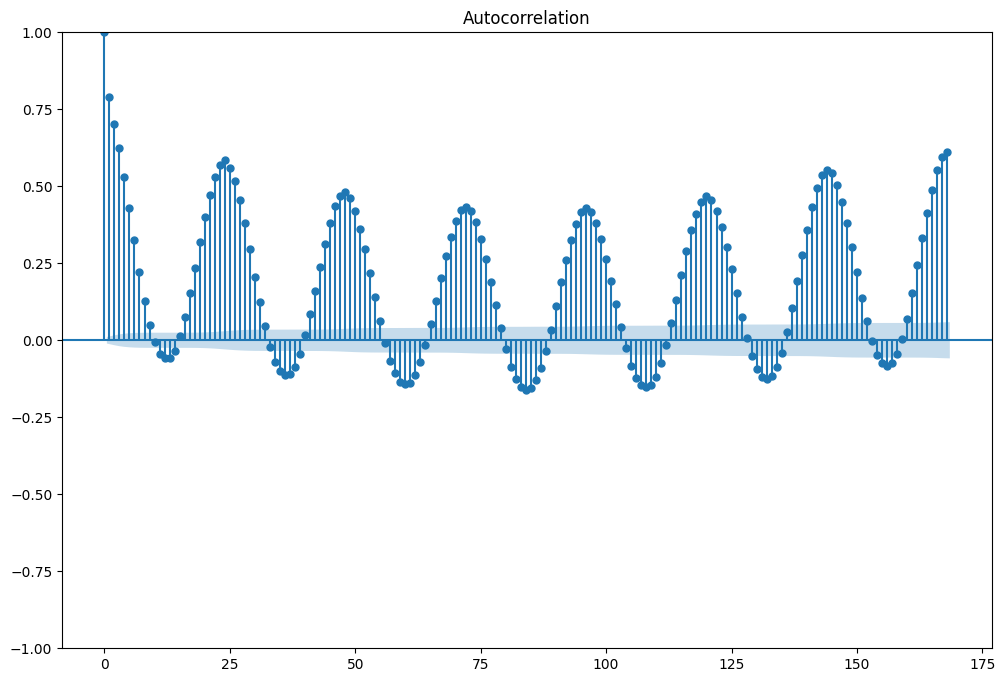

In [ ]:
# Grafico ACF
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(datos["AE"], ax=ax, lags=168)
plt.show()

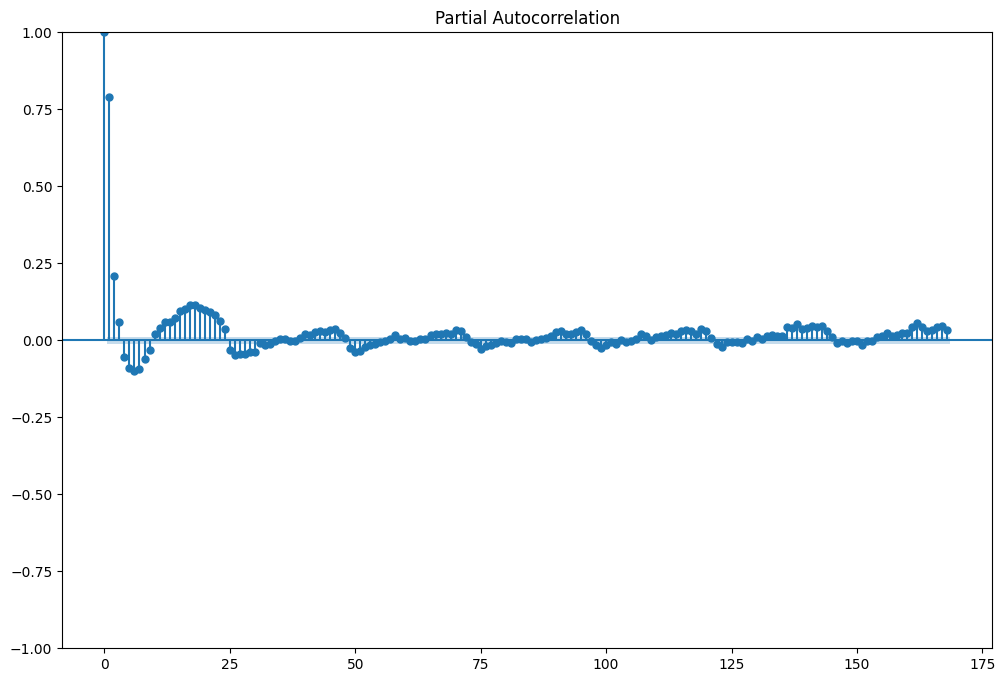

In [ ]:
# Grafico PACF
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(datos["AE"], ax=ax, lags=168)
plt.show()


This code calculates the autocorrelation of the series up to `168` time lags (one week of hourly data). It shows how current values are related to past observations.

In [ ]:
lag_ACF = calculate_lag_autocorrelation(
    data=datos["AE"], n_lags=168, sort_by="partial_autocorrelation_abs"
).head(10)

print(lag_ACF)

   lag  partial_autocorrelation_abs  partial_autocorrelation  \
0    1                     0.788537                 0.788537   
1    2                     0.209131                 0.209131   
2   17                     0.116169                 0.116169   
3   18                     0.113086                 0.113086   
4   19                     0.103980                 0.103980   
5   16                     0.102605                 0.102605   
6    6                     0.098657                -0.098657   
7   20                     0.098624                 0.098624   
8   15                     0.093848                 0.093848   
9   21                     0.091947                 0.091947   

   autocorrelation_abs  autocorrelation  
0             0.788514         0.788514  
1             0.700844         0.700844  
2             0.151909         0.151909  
3             0.235331         0.235331  
4             0.318625         0.318625  
5             0.074712         0.074712  
6

# **Evaluation Metric**


The following error metrics are used to evaluate the models:

### Mean Absolute Error (MAE)

$$
MAE = \frac{1}{n} \sum_{t=1}^{n} \left| y_t - \hat{y}_t \right|
$$

---

### Root Mean Squared Error (RMSE)

$$
RMSE = \sqrt{ \frac{1}{n} \sum_{t=1}^{n} \left( y_t - \hat{y}_t \right)^2 }
$$

---

### Coefficient of Determination (R²)

$$
R^2 = 1 - \frac{ \sum_{t=1}^{n} (y_t - \hat{y}_t)^2 }{ \sum_{t=1}^{n} (y_t - \bar{y})^2 }
$$

where:  
- yₜ = true value at time t  
- ŷₜ = predicted value at time t  
- ȳ = mean of the observed values  
- n = number of observations

`Set_scorer` define metrics names to `scikit-learn` scores, using negative values for errors (higher is better).

In [18]:
def set_scorer(scorer):
    if scorer == "mae":
        return "neg_mean_absolute_error"
    elif scorer == "rmse":
        return "neg_mean_squared_error"
    elif scorer == "r2":
        return "r2"
    else:
        raise ValueError(f"Scorer {scorer} not implemented.")


# **MODELS**

# **SARIMA**

First,  SARIMA model is trained using the past 24 hours of data `(lags = 24)` to predict future consumption. Trained on the data up to the validation period the execution time is measured.

At the end, the estimated parameters / feature importances are displayed.

The model took about 233 seconds to train. The results shows that the first lag `(ar.L1)` is the most important, `ar.L24` also relevant. Some lags are negative, `ma.L1 `has the most negative effect, showing short-term and daily variations.

In [26]:

lags = 24

forecaster_arima = ForecasterSarimax(
    regressor=Sarimax(order=(lags, 1, 1), maxiter=200)
)

# Calculate the execution time
start_time = time.time()

forecaster_arima.fit(y=datos.loc[:val_ends, "AE"])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

best_params = (
    forecaster_arima.get_feature_importances()
    if hasattr(forecaster_arima, "get_feature_importances") else {}
)
print("Best Params:")
print(best_params)


Execution time: 173.95 seconds
Best Params:
   feature   importance
25  sigma2  1100.733051
0    ar.L1     0.251902
23  ar.L24     0.078828
22  ar.L23     0.051184
21  ar.L22     0.032704
2    ar.L3     0.030721
1    ar.L2     0.028308
20  ar.L21     0.009287
3    ar.L4    -0.008953
19  ar.L20    -0.008974
18  ar.L19    -0.020736
4    ar.L5    -0.024803
17  ar.L18    -0.026983
16  ar.L17    -0.038014
5    ar.L6    -0.038698
11  ar.L12    -0.048308
14  ar.L15    -0.054312
15  ar.L16    -0.055627
12  ar.L13    -0.058038
10  ar.L11    -0.058355
9   ar.L10    -0.058942
6    ar.L7    -0.059781
7    ar.L8    -0.067746
13  ar.L14    -0.068320
8    ar.L9    -0.080473
24   ma.L1    -0.759063


To be able to capture `trends`, and `seasonal patterns`, we apply `backtesting` to evaluate the SARIMA model. Performances are tested through time series cross-validation with the `TimeSeriesFold` function, first on the training set with rolling windows and then on the test set to see how it performs on the new data.

In [27]:

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


metrics = {
    "MAE": mean_absolute_error,
    "RMSE": rmse,
    "R2": r2_score
}


cv_train = TimeSeriesFold(
    steps=steps, initial_train_size=8760 * 3, fixed_train_size=True, refit=False
)

metrics_results_train, predicciones_train = backtesting_sarimax(
    forecaster=forecaster_arima,
    y=datos["AE"],
    cv=cv_train,
    metric=list(metrics.values()),
    verbose=False,
)


metrics_results_train.columns = list(metrics.keys())
print("Results for the training set:")
print(metrics_results_train)


cv_test = TimeSeriesFold(
    steps=steps,
    initial_train_size=len(datos.loc[:val_ends]),
    fixed_train_size=True,
    refit=False,
)


metrics_results_test, predicciones_test = backtesting_sarimax(
    forecaster=forecaster_arima,
    y=datos["AE"],
    cv=cv_test,
    metric=list(metrics.values()),
    verbose=False,
)

metrics_results_test.columns = list(metrics.keys())
print("Results for the generalization set:")
print(metrics_results_test)


  0%|          | 0/305 [00:00<?, ?it/s]

Results for the training set:
         MAE       RMSE        R2
0  30.345211  40.358302  0.442472


  0%|          | 0/59 [00:00<?, ?it/s]

Results for the generalization set:
         MAE       RMSE       R2
0  25.765347  35.544824  0.42197


To better understand the results obtained, a dataFrame is created containing the real values `y_test_real` and predicted ones `df_pred_test` to see how accurate the model’s predictions to the real ones.

In [38]:
# --- Get the actual values ---
y_train_real = datos["AE"].iloc[:len(predicciones_train)]
y_test_real = datos["AE"].iloc[-len(predicciones_test):]

df_pred_test = pd.DataFrame({
    'Real': y_test_real.values,
    'Predicted': predicciones_test.values.flatten()
})


print("\n predictions vs Real:")
df_pred_test.head(10)




 predictions vs Real:


Real   Predicted
0   160  149.700160
1   197  131.449881
2   178  119.866637
3   151  113.423916
4   116  107.653310
5    60  105.074897
6    56  103.290560
7    60  104.852204
8    96  111.542738
9    68  117.726622

To see how well the **SARIMA** model captures the real values, we plot the predicted data against the real (actual) values.

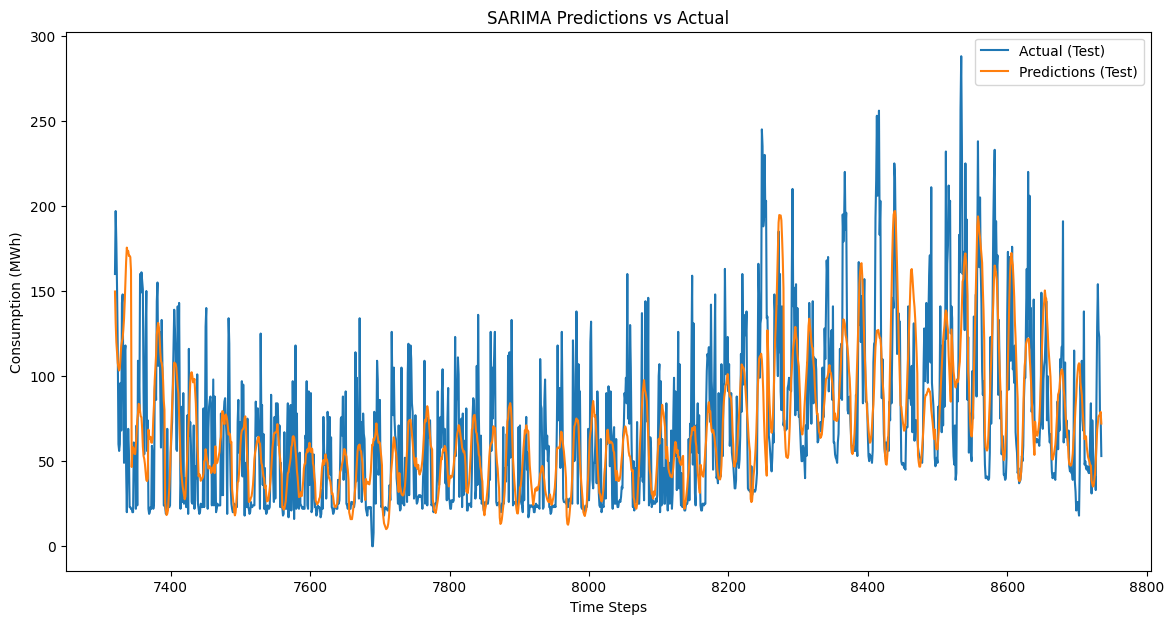

In [40]:
plt.figure(figsize=(14,7))

n_total = len(datos["AE"])
n_train = len(y_train_real)
n_test = len(y_test_real)


ActualPlot = np.empty(n_total, dtype=float)
ActualPlot[:] = np.nan
ActualPlot[n_train:n_train+n_test] = y_test_real.values
plt.plot(ActualPlot, label="Actual (Test)")

TestPredictionsPlot = np.empty(n_total, dtype=float)
TestPredictionsPlot[:] = np.nan
TestPredictionsPlot[n_train:n_train+n_test] = predicciones_test.values.flatten()
plt.plot(TestPredictionsPlot, label="Predictions (Test)")

plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Consumption (MWh)")
plt.title("SARIMA Predictions vs Actual")
plt.show()


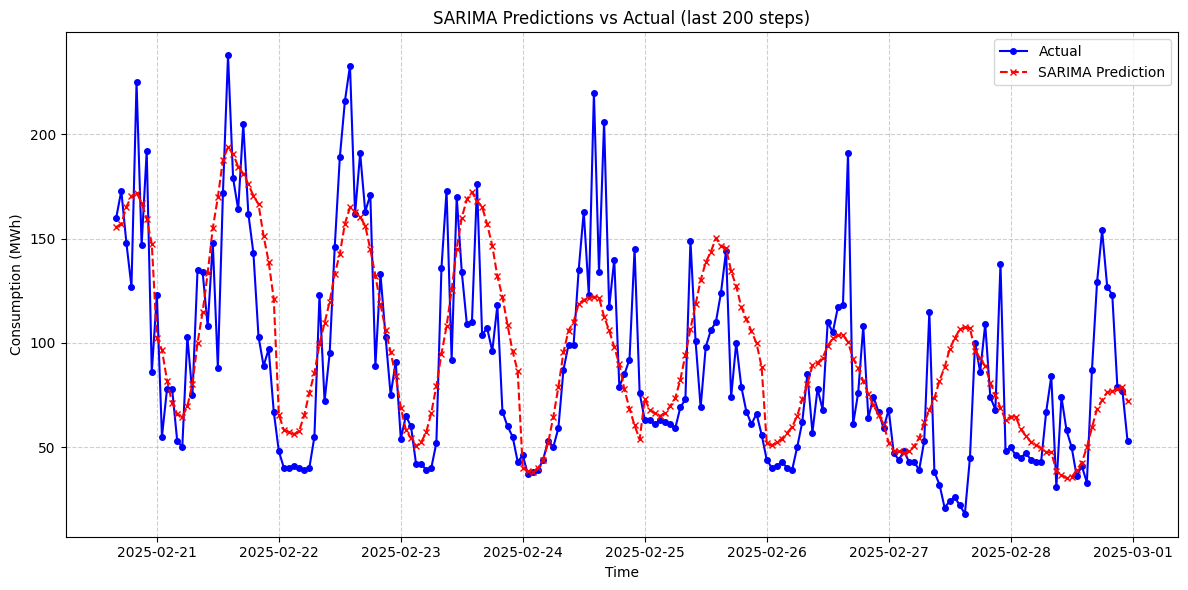

In [41]:
import matplotlib.pyplot as plt

N = 200  # nombre de points à afficher (zoom)

plt.figure(figsize=(12, 6))

plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Actual",
    color="blue",
    marker="o",
    markersize=4,
    linestyle="-"
)

plt.plot(
    y_test.index[-N:],
    predicciones_test[-N:],
    label="SARIMA Prediction",
    color="red",
    linestyle="dashed",
    marker="x",
    markersize=4
)

plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.title(f"SARIMA Predictions vs Actual (last {N} steps)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# **MODELS**

### **set_estimator functio**n

We start by defining the `set_estimator` function, which makes it easier to set up and train some models `( Ridge and XGBOOST)`. For each model, a grid of hyperparameters is defined, such as `alpha` for **Ridge** or `n_estimators`, `max_depth`, and `learning_rate` for **XGBoost**.


it uses `GridSearchCV` to test all possibilities.

In [28]:

def set_estimator(estimator_name, random_state, scorer, n_jobs=-1, cv=3):
    estimator_name = estimator_name.lower()

    if estimator_name == "ridge":
        from sklearn.linear_model import Ridge
        param_grid = {
            "alpha": np.logspace(-6, 6, 13),
            "max_iter": [100, 500, 1000],
        }
        model = Ridge(random_state=random_state)

    elif estimator_name == "xgboost":
        from xgboost import XGBRegressor
        param_grid = {
            "n_estimators": [100, 500],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1],
        }
        model = XGBRegressor(random_state=random_state)

    else:
        raise NotImplementedError(f"{estimator_name} not implemented.")

    return GridSearchCV(
        model,
        param_grid,
        scoring=set_scorer(scorer),
        cv=cv,
        n_jobs=n_jobs,
        refit=True
    )

### **create_lagged_features function**

This cell, creates a function to generate lagged features from the time series which are pasts values that are used as predictors. Here we generate up to `168 lags` ( `7 days * 24 hours`) which covers a full week of hourly consumption. This let us use past observations to predict future values.

After that, the lagged dataset is split into **X** (`Lagged variables`) and **Y** (`Actual electricity consumption`). The model uses **X** to learn and predict **Y**.

In [29]:
def create_lagged_features(series, lags=24):
    df = pd.DataFrame(series)
    for lag in range(1, lags+1):
        df[f"lag_{lag}"] = df["AE"].shift(lag)
    df = df.dropna()
    return df

lags = 168


df_lagged = create_lagged_features(datos, lags=lags)

X = df_lagged.drop(columns=["AE"])
y = df_lagged["AE"]


### **Train, validation, and test sets**

The data is split into **train**, **validation**, and **test** sets by time. Then, train and validation are combined into **trainval** to retrain the model before the final test.

In [30]:
X_train = X.loc[datos_train.index.intersection(X.index)]
y_train = y.loc[datos_train.index.intersection(y.index)]

X_val = X.loc[datos_val.index.intersection(X.index)]
y_val = y.loc[datos_val.index.intersection(y.index)]

X_test = X.loc[datos_test.index.intersection(X.index)]
y_test = y.loc[datos_test.index.intersection(y.index)]


In [31]:
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])


# **Ridge Regression**

We prepare Ridge Regression by **splitting** the data in time order (3 parts) with `TimeSeriesSplit`, **scaling** the features with `StandardScaler`, all grouped in a Pipeline to keep the process consistent.

In [32]:
cv = TimeSeriesSplit(n_splits=3)
scaler = StandardScaler()
ridge_search = set_estimator("ridge", random_state=42, scorer="mae", cv=cv)

model = Pipeline([
    ('scaler', scaler),
    ('model', ridge_search)
])


The model is trained on the training set, then used to predict **X_test**. Its performance is measured with the metrics to see the accuracy.

In [33]:
 # ----------------- 4. Training and predictions ----------------
model.fit(X_train, y_train)
 y_pred_ridge = model.predict(X_test)
 mae = mean_absolute_error(y_test, y_pred_ridge)
 rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
 r2 = r2_score(y_test, y_pred_ridge)
 print(f"MAE  : {mae:.2f}")
 print(f"RMSE : {rmse:.2f}")
 print(f"R²   : {r2:.2f}")

MAE  : 21.74
RMSE : 29.50
R²   : 0.60


To better understand the results obtained, a dataFrame is created containing the real values `y_test` and predicted ones `y_pred` to see how accurate the model’s predictions to the real ones.

In [34]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions
    y_pred_ridge = model.predict(X_test)

    # Display the predictions vs real
    df_pred = pd.DataFrame({
        'Réel': y_test.values if hasattr(y_test, "values") else y_test,
        'Prédit': y_pred_ridge
    })
    print(f"\nActual vs. Predicted Comparison ({model_name}):")
    print(df_pred.head(10))


    return y_pred_ridge


# 🔹 Appel de la fonction d’évaluation
y_pred_ridge = evaluate_model(model, X_test, y_test, "Ridge")


Actual vs. Predicted Comparison (Ridge):
   Réel      Prédit
0   160  135.232791
1   197  121.920550
2   178  140.606230
3   151  136.998247
4   116  134.506881
5    60  119.592637
6    56   94.364197
7    60   92.084000
8    96   94.215946
9    68  115.313793


In [35]:
df_pred = pd.DataFrame({
    'Real': y_test,
    'Predicted': y_pred_ridge
})
df_pred.head(10)

Real   Predicted
Fecha                                
2025-01-01 00:00:00   160  135.232791
2025-01-01 01:00:00   197  121.920550
2025-01-01 02:00:00   178  140.606230
2025-01-01 03:00:00   151  136.998247
2025-01-01 04:00:00   116  134.506881
2025-01-01 05:00:00    60  119.592637
2025-01-01 06:00:00    56   94.364197
2025-01-01 07:00:00    60   92.084000
2025-01-01 08:00:00    96   94.215946
2025-01-01 09:00:00    68  115.313793

To see how well the **Ridge** model captures the real values, we plot the predicted data against the real (actual) values.

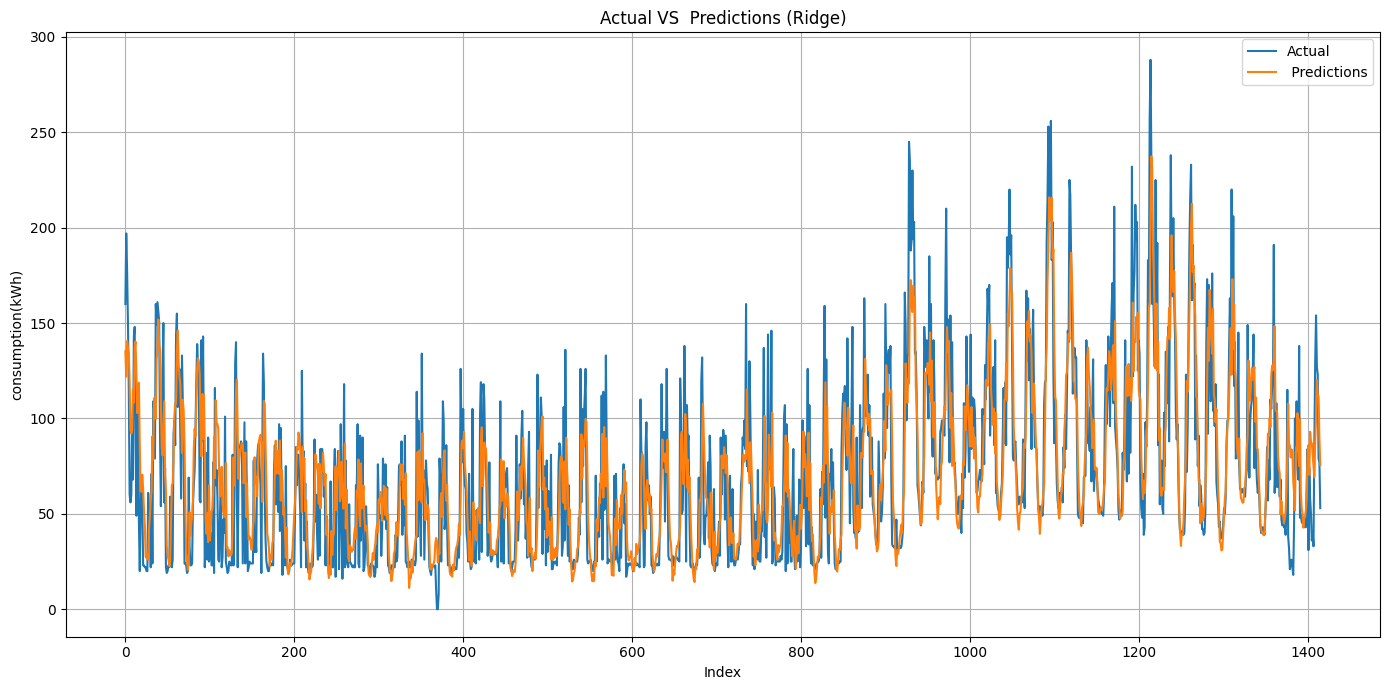

In [36]:


plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_ridge, label=' Predictions')
plt.title("Actual VS  Predictions (Ridge)")
plt.xlabel("Index")
plt.ylabel("consumption(kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



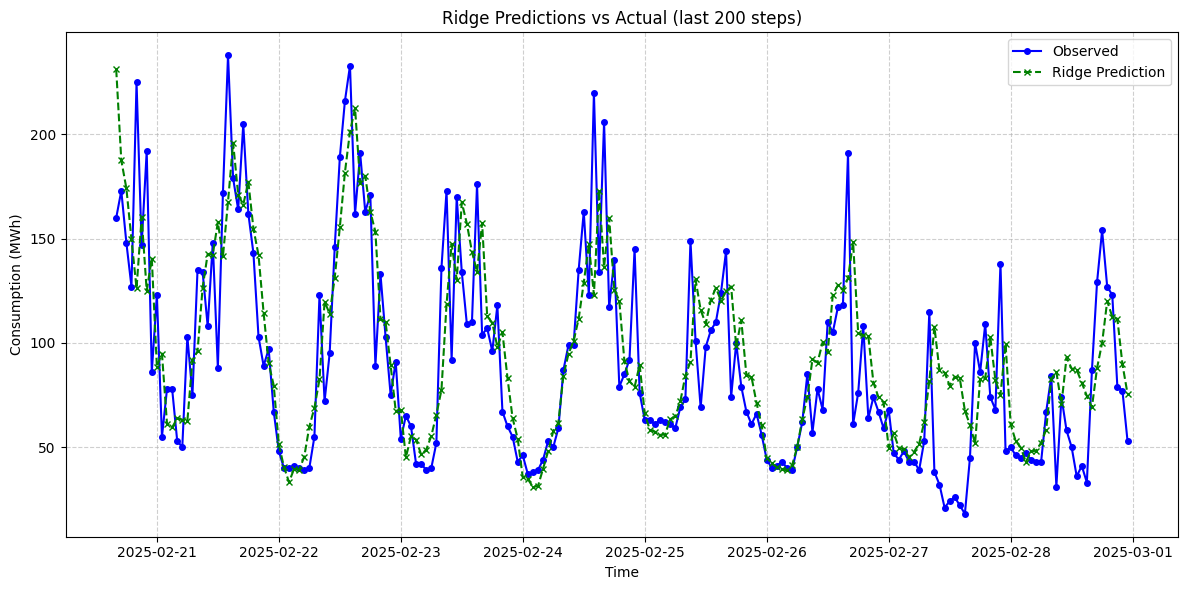

In [37]:
N = 200

plt.figure(figsize=(12, 6))

plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Observed",
    color="blue",
    marker="o",
    markersize=4,
    linestyle="-"
)

plt.plot(
    y_test.index[-N:],
    y_pred_ridge[-N:],
    label="Ridge Prediction",
    color="green",
    linestyle="dashed",
    marker="x",
    markersize=4
)

plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.title(f"Ridge Predictions vs Actual (last {N} steps)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# **XGBoost Regressor**

For the next stochastic models, results can vary a little each time the model is trained. To ensure stable results, we perform **10 runs**, training and testing the model multipe times using different seeds. Before training, the features are `scaled` so all the input values are on the same rage helping the model learn better.

In each run, the model is trained on the training set, makes predictions on the test set, the metric are calculated and all the results are saved for comparaison.

In [ ]:
model_name = "xgboost"
scorer = "mae"
n_runs = 10
results = []

for run in range(n_runs):
    print(f"\n Run {run + 1}/10")

    seed = 42 + run
    cv = TimeSeriesSplit(n_splits=3)

    search_model = set_estimator(model_name, random_state=seed, scorer=scorer, cv=cv)

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', search_model)
    ])


    model.fit(X_train, y_train)


    y_pred_xgb = model.predict(X_test)



    mae = mean_absolute_error(y_test, y_pred_xgb)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    r2 = r2_score(y_test, y_pred_xgb)

    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")


    results.append({
        "run": run + 1,
        "seed": seed,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })


 Run 1/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 2/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 3/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 4/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 5/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 6/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 7/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 8/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 9/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61

 Run 10/10
MAE  : 21.63
RMSE : 29.31
R²   : 0.61


To better understand the results obtained, a dataFrame is created containing the real values `y_test` and predicted ones `y_pred` to see how accurate the model’s predictions to the real ones.

In [48]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)

    # Display the predictions vs real
    df_pred = pd.DataFrame({
        'Réel': y_test.values if hasattr(y_test, "values") else y_test,
        'Prédit': y_pred_xgb
    })
    print(f"\nActual vs. Predicted Comparison ({model_name}):")
    print(df_pred.head(10))


    return y_pred_xgb


# 🔹 Appel de la fonction d’évaluation
y_pred_xgb = evaluate_model(model, X_test, y_test, "XGBOOST")


Actual vs. Predicted Comparison (XGBOOST):
   Réel      Prédit
0   160  149.200241
1   197  113.887497
2   178  143.578796
3   151  127.225037
4   116  112.050591
5    60   81.615601
6    56   65.920517
7    60   75.528755
8    96   80.882889
9    68  113.631554


In [49]:
df_pred = pd.DataFrame({
    'Real': y_test,
    'Predicted': y_pred_xgb
})
df_pred.head(10)

Real   Predicted
Fecha                                
2025-01-01 00:00:00   160  149.200241
2025-01-01 01:00:00   197  113.887497
2025-01-01 02:00:00   178  143.578796
2025-01-01 03:00:00   151  127.225037
2025-01-01 04:00:00   116  112.050591
2025-01-01 05:00:00    60   81.615601
2025-01-01 06:00:00    56   65.920517
2025-01-01 07:00:00    60   75.528755
2025-01-01 08:00:00    96   80.882889
2025-01-01 09:00:00    68  113.631554

To see how well the **XGBOOST** model captures the real values, we plot the predicted data against the real (actual) values.

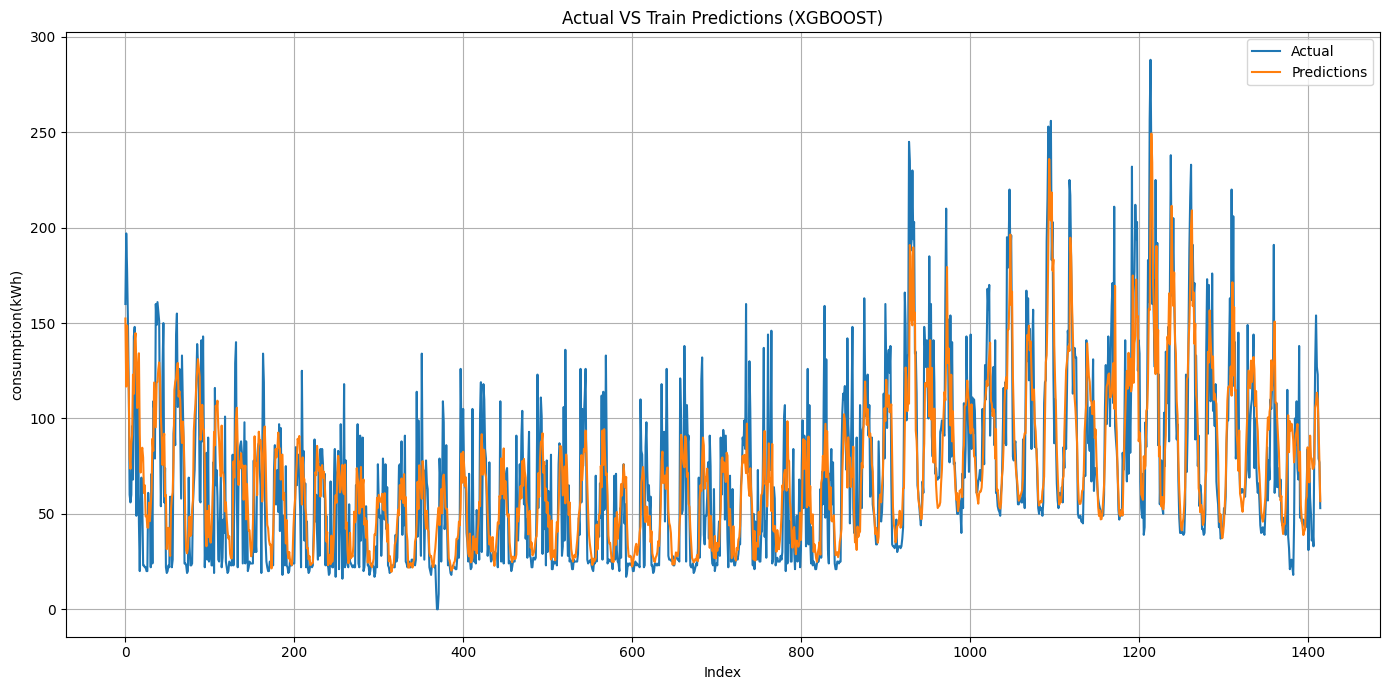

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_xgb, label='Predictions')
plt.title("Actual VS Train Predictions (XGBOOST)")
plt.xlabel("Index")
plt.ylabel("consumption(kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


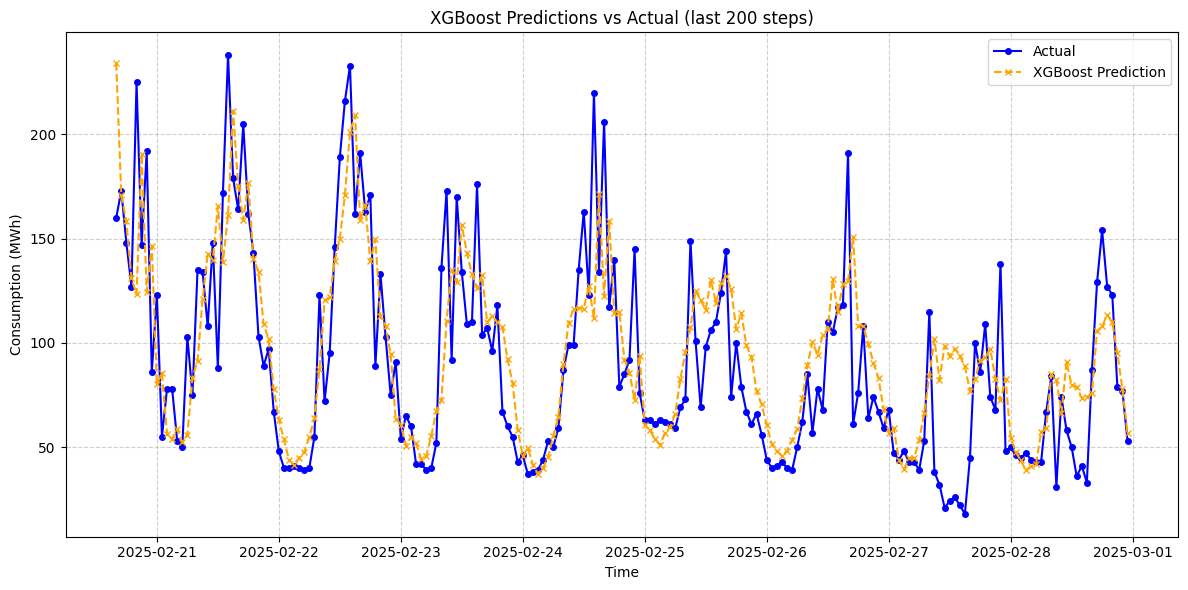

In [ ]:
N = 200

plt.figure(figsize=(12, 6))

plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Actual",
    color="blue",
    marker="o",
    markersize=4,
    linestyle="-"
)

plt.plot(
    y_test.index[-N:],
    y_pred[-N:],
    label="XGBoost Prediction",
    color="orange",
    linestyle="dashed",
    marker="x",
    markersize=4
)

plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.title(f"XGBoost Predictions vs Actual (last {N} steps)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# **RANDOM FOREST**

Next, we are going to explore  **Random Forest Regressor**  model. The model is built with 500 trees, each split needs at least 2 samples and each leaf at least 1 , the model uses the square root of features for splits, a random seed for reproducibility. we will run the model 10 times with different seeds to check the consistency of its performance.

In [ ]:
print(f"\n========= RandomForest =========")
n_runs = 10
results_rf = []

for run in range(n_runs):
    seed = 42 + run
    print(f"\n Run {run + 1} - Seed: {seed}")

    model_rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        random_state=seed,
        n_jobs=-1
    )


    model_rf.fit(X_train, y_train)


    y_pred_rf = model_rf.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred_rf)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2 = r2_score(y_test, y_pred_rf)

    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

    results_rf.append({"run": run + 1, "MAE": mae, "RMSE": rmse, "R2": r2})


========= RandomForest =========

 Run 1 - Seed: 42
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 2 - Seed: 43
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 3 - Seed: 44
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 4 - Seed: 45
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 5 - Seed: 46
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 6 - Seed: 47
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 7 - Seed: 48
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 8 - Seed: 49
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 9 - Seed: 50
MAE  : 21.35
RMSE : 29.18
R²   : 0.61

 Run 10 - Seed: 51
MAE  : 21.35
RMSE : 29.18
R²   : 0.61


To better understand the results obtained, a dataFrame is created containing the real values `y_test` and predicted ones `y_pred` to see how accurate the model’s predictions to the real ones.

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions
    y_pred_rf = model.predict(X_test)

    # Display the predictions vs real
    df_pred = pd.DataFrame({
        'Réel': y_test.values if hasattr(y_test, "values") else y_test,
        'Prédit': y_pred_rf
    })
    print(f"\nActual vs. Predicted Comparison ({model_name}):")
    print(df_pred.head(10))


    return y_pred


# 🔹 Appel de la fonction d’évaluation
y_pred_rf = evaluate_model(model_rf, X_test, y_test, "Random Forest")



Actual vs. Predicted Comparison (Random Forest):
   Réel   Prédit
0   160  116.118
1   197  107.740
2   178  104.406
3   151  105.068
4   116  101.300
5    60   80.968
6    56   69.584
7    60   83.506
8    96   91.344
9    68  117.162


To see how well the **RANDOM FOREST** model captures the real values, we plot the predicted data against the real (actual) values.

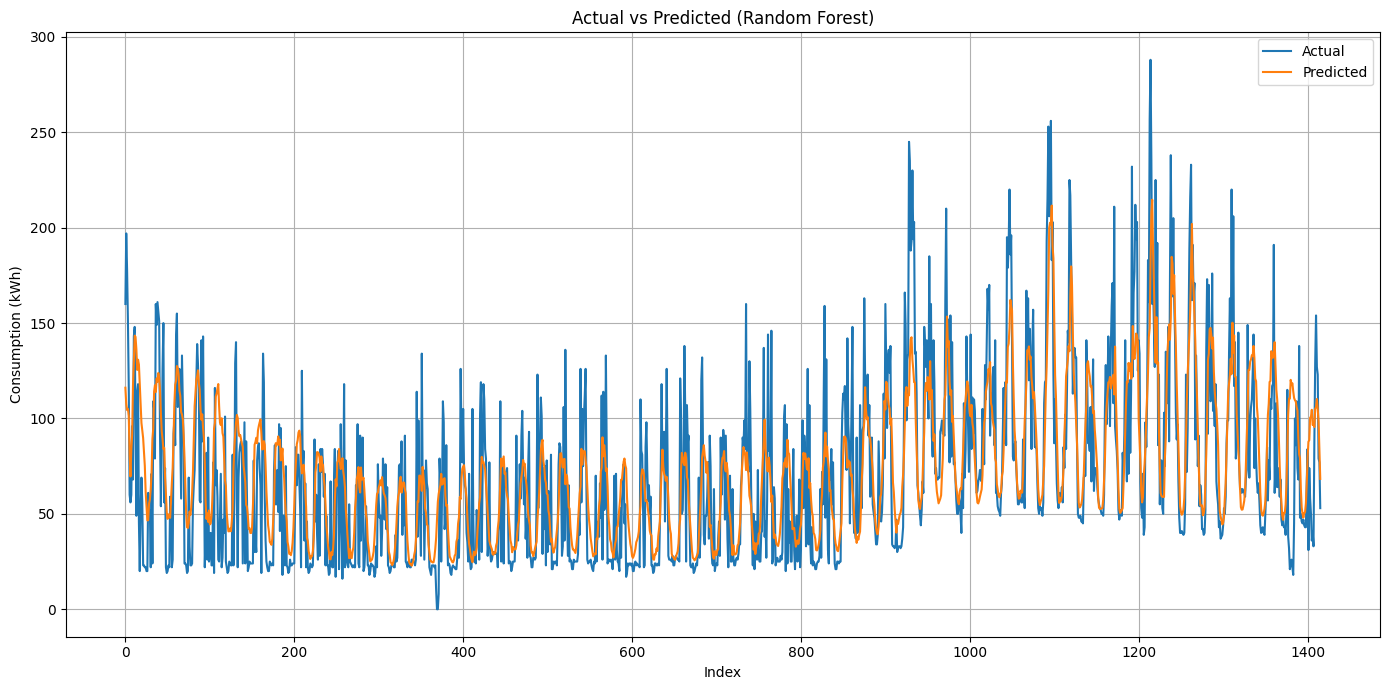

In [ ]:
plt.figure(figsize=(14, 7))


plt.plot(y_test.values, label='Actual')

plt.plot(y_pred_rf.flatten(), label='Predicted')

plt.title("Actual vs Predicted (Random Forest)")
plt.xlabel("Index")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

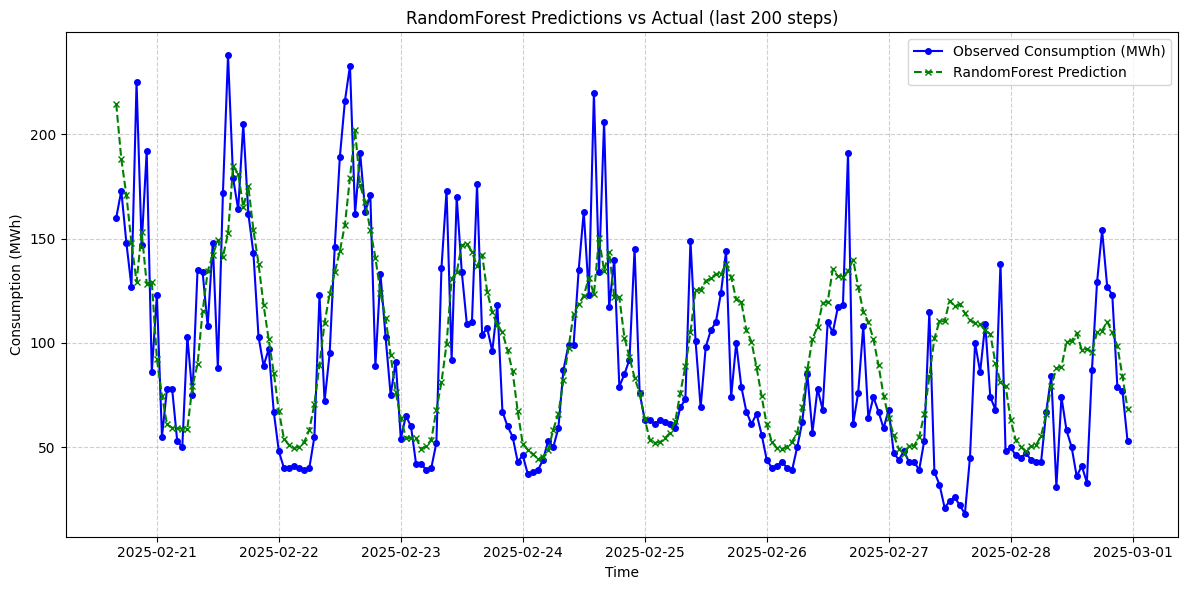

In [ ]:
import matplotlib.pyplot as plt

N = 200  # nombre de points à afficher (zoom sur la fin du test)

plt.figure(figsize=(12, 6))

# Observed values
plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Observed Consumption (MWh)",
    color="blue",
    marker="o",
    markersize=4,
    linestyle="-"
)

# RandomForest predictions
plt.plot(
    y_test.index[-N:],
    y_pred_rf[-N:],
    label="RandomForest Prediction",
    color="green",
    linestyle="dashed",
    marker="x",
    markersize=4
)

plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.title(f"RandomForest Predictions vs Actual (last {N} steps)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# **Support Vector Regression (SVR)**

This section implement a **Support Vector Regression (SVR)** from `sklearn.svm` where the input features are first `normalized` (`scaled`) with `MinMaxScaler` to ensure all values are on a same scale, which helps the model work better. The model is trained on the training set and predictions are made for the training, validation, and test sets, the metric are calculated to evaluate the model’s accuracy.

In [ ]:

print("\n========= SVR =========")

# Scaling
scaler = MinMaxScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_s   = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#  SVR
model_svr = SVR()
model_svr.fit(X_train_s, y_train)


def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label.upper():<6} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}")

y_train_pred = model_svr.predict(X_train_s)
evaluate(y_train, y_train_pred, label="Train")

y_val_pred = model_svr.predict(X_val_s)
evaluate(y_val, y_val_pred, label="Valid")

y_test_pred = model_svr.predict(X_test_s)
evaluate(y_test, y_test_pred, label="Test")


========= SVR =========
TRAIN  | MAE: 26.04 | RMSE: 38.34 | R²: 0.61
VALID  | MAE: 22.71 | RMSE: 31.41 | R²: 0.65
TEST   | MAE: 22.32 | RMSE: 31.19 | R²: 0.55


In [ ]:

def evaluate_model(model, X, y, model_name):
    # Predictions
    y_pred = model.predict(X)

    # Display predictions vs real values
    df_pred = pd.DataFrame({
        'Actual': y.values if hasattr(y, "values") else y,
        'Predicted': y_pred
    })
    print(f"\nActual vs. Predicted Comparison ({model_name}):")
    print(df_pred.head(10))

    return y_pred

# 🔹 Exemple d’appel
y_pred_svr = evaluate_model(model_svr, X_test_s, y_test, "SVR")



Actual vs. Predicted Comparison (SVR):
   Actual   Predicted
0     160   96.095910
1     197   82.770024
2     178   84.185442
3     151   84.004955
4     116   81.946958
5      60   79.033960
6      56   77.823560
7      60   87.609076
8      96  101.303242
9      68  120.356637


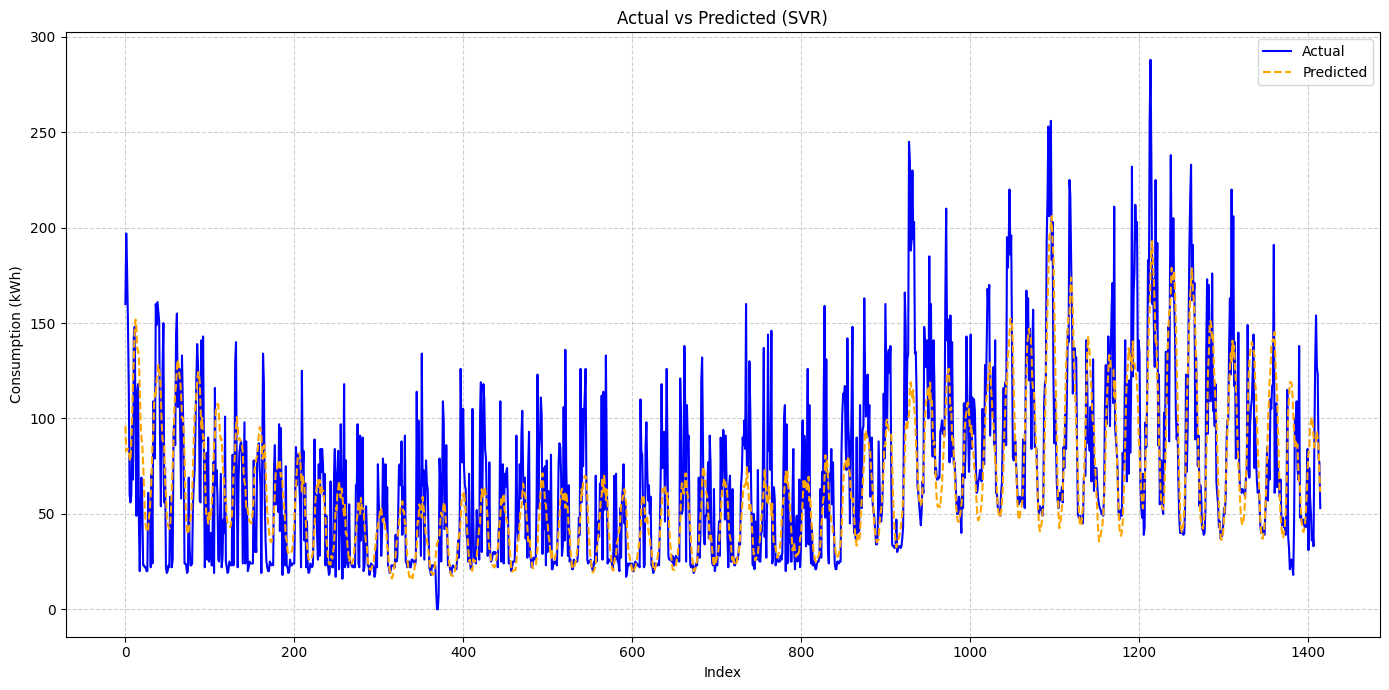

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))


plt.plot(y_test.values, label='Actual', color='blue')


plt.plot(y_pred_svr, label='Predicted', color='orange', linestyle='dashed')

plt.title("Actual vs Predicted (SVR)")
plt.xlabel("Index")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


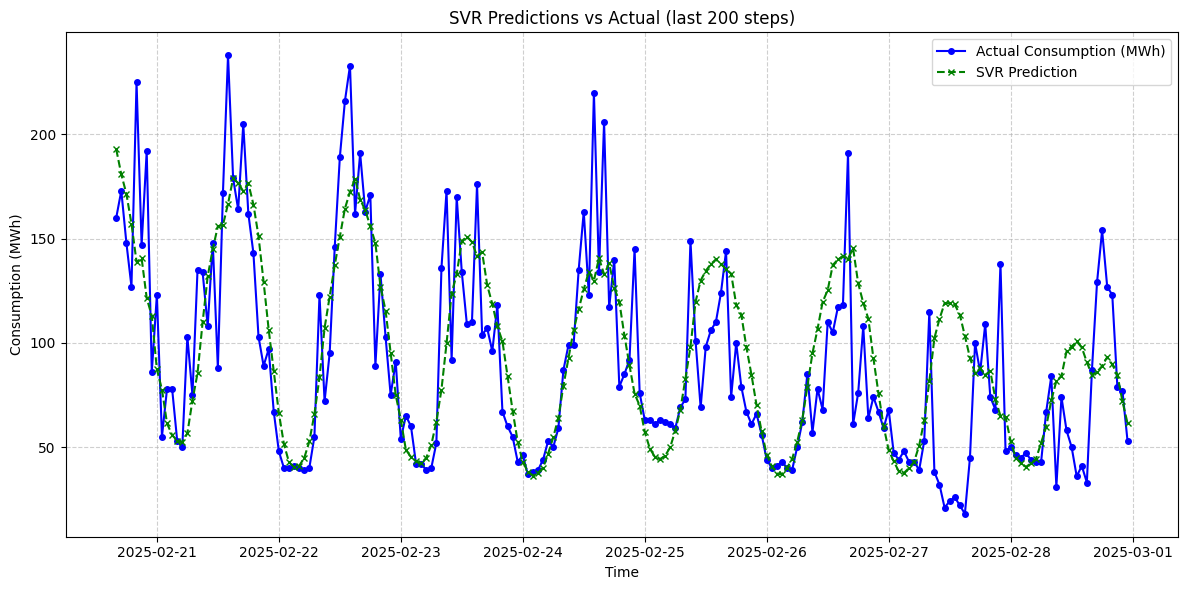

In [ ]:
import matplotlib.pyplot as plt

N = 200  # nombre de points à afficher (zoom sur la fin du test)

plt.figure(figsize=(12, 6))

# Observed values
plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Actual Consumption (MWh)",
    color="blue",
    marker="o",
    markersize=4,
    linestyle="-"
)

# SVR predictions
plt.plot(
    y_test.index[-N:],
    y_pred_svr[-N:],  # <- ici on utilise y_pred_svr
    label="SVR Prediction",
    color="green",
    linestyle="dashed",
    marker="x",
    markersize=4
)

plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.title(f"SVR Predictions vs Actual (last {N} steps)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# **CNN (Convolutional Neural Networks)**

**Convolutional neural networks (CNNs)** are commonly used for time series forecasting tasks. The model takes the lagged time series as a **1D** input signal, applies convolution and pooling operations to extract temporal features, and passes through fully connected layers to make prediction https://github.com/adamd1985/Temporal_Convolution_Networks_for_Energy_Demand_Forecast/blob/main/nn_model.ipynb



First, the inputs are scaled with `MinMaxScaler` to bring all the value between 0 and 1, this data is reshaped to match the CNN input format `(samples, timesteps, features).`

We define the architecture with the function `cnn_model` which consists of three convolutional layers with increasing filters (64, 128, 256), each followed by batch normalization, pooling and dropout to reduce overfitting. After these layers, a dense layer with 128 units leads to the final output layer for nregression and the model use MSE loss and Adam oprimizer.

The training is repeated 10 times with differents seeds, the epoch executions are hidden for clarity and to simplify result visualization. For each run, we create a new model and reset the seed, train it, then make predictions.

In [ ]:

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)


X_train_s = X_train_s.reshape((X_train_s.shape[0], X_train_s.shape[1], 1))
X_val_s   = X_val_s.reshape((X_val_s.shape[0], X_val_s.shape[1], 1))
X_test_s  = X_test_s.reshape((X_test_s.shape[0], X_test_s.shape[1], 1))


def cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=3, padding="same", activation="relu", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, padding='same'),
        layers.Dropout(0.3),

        layers.Conv1D(128, kernel_size=3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, padding='same'),
        layers.Dropout(0.3),

        layers.Conv1D(256, kernel_size=3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),

        layers.Dense(128, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(1)  # régression
    ])
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model



input_shape = (X_train_s.shape[1], X_train_s.shape[2])


model = cnn_model(input_shape)

model.summary()

def reset_seeds(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

n_runs = 10
results = []

for run in range(n_runs):
    print(f"\n Run {run + 1}")
    seed = 42 + run
    reset_seeds(seed)


    model = cnn_model(input_shape)


    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


    history = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )


    y_val_pred = model.predict(X_val_s, verbose=0).flatten()


    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

    results.append({'run': run+1, 'Seed': seed, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 171, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 171, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 86, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 43, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,337 (618.50 KB)

 Trainable params: 157,441 (615.00 KB)

 Non-trainable params: 896 (3.50 KB)


 Run 1
MAE  : 22.35
RMSE : 30.11
R²   : 0.68

 Run 2
MAE  : 22.40
RMSE : 29.96
R²   : 0.68

 Run 3
MAE  : 22.43
RMSE : 30.00
R²   : 0.68

 Run 4
MAE  : 22.58
RMSE : 30.03
R²   : 0.68

 Run 5
MAE  : 22.34
RMSE : 30.10
R²   : 0.68

 Run 6
MAE  : 22.61
RMSE : 29.99
R²   : 0.68

 Run 7
MAE  : 22.40
RMSE : 29.99
R²   : 0.68

 Run 8
MAE  : 22.41
RMSE : 30.02
R²   : 0.68

 Run 9
MAE  : 22.41
RMSE : 29.94
R²   : 0.68

 Run 10
MAE  : 22.73
RMSE : 30.02
R²   : 0.68


To better understand the results obtained, a dataFrame is created containing the real values `y_test` and predicted ones `y_pred` to see how accurate the model’s predictions to the real ones.

In [45]:

y_test_pred = model.predict(X_test_s, verbose=0).flatten()


df_pred = pd.DataFrame({
    "Actual": y_test.values if hasattr(y_test, "values") else y_test,
    "Predicted": y_test_pred
})

print("\nFirst 10 predictions vs actual (test):")
print(df_pred.head(10))




First 10 predictions vs actual (test):
   Actual   Predicted
0     160  146.198624
1     197  131.336197
2     178  116.954376
3     151  127.402740
4     116  119.610954
5      60   99.248703
6      56   63.468273
7      60   66.899261
8      96   82.133591
9      68   97.983955


To see how well the **CNN** model captures the real values, we plot the predicted data against the real (actual) values.

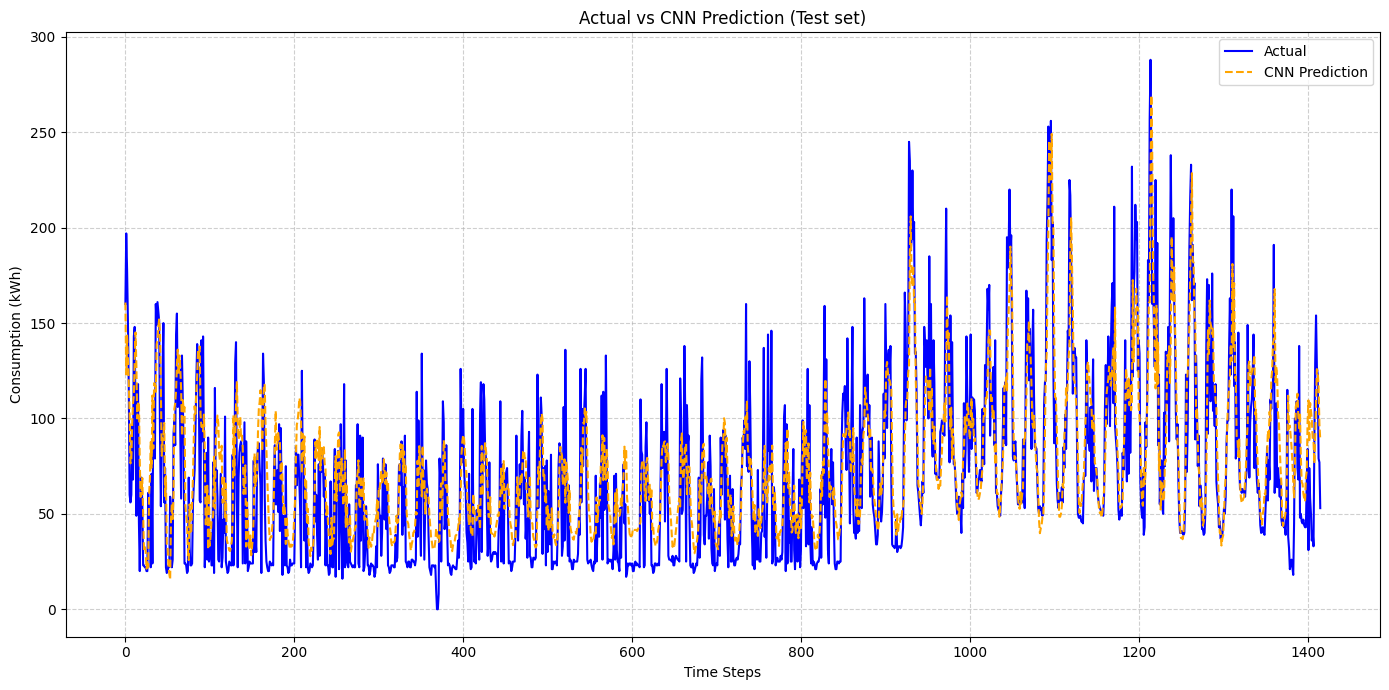

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(
    y_test.values if hasattr(y_test, "values") else y_test,
    label='Actual',
    color="blue"
)

plt.plot(
    y_test_pred,
    label='CNN Prediction',
    color="orange",
    linestyle="dashed"
)

plt.title("Actual vs CNN Prediction (Test set)")
plt.xlabel("Time Steps")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


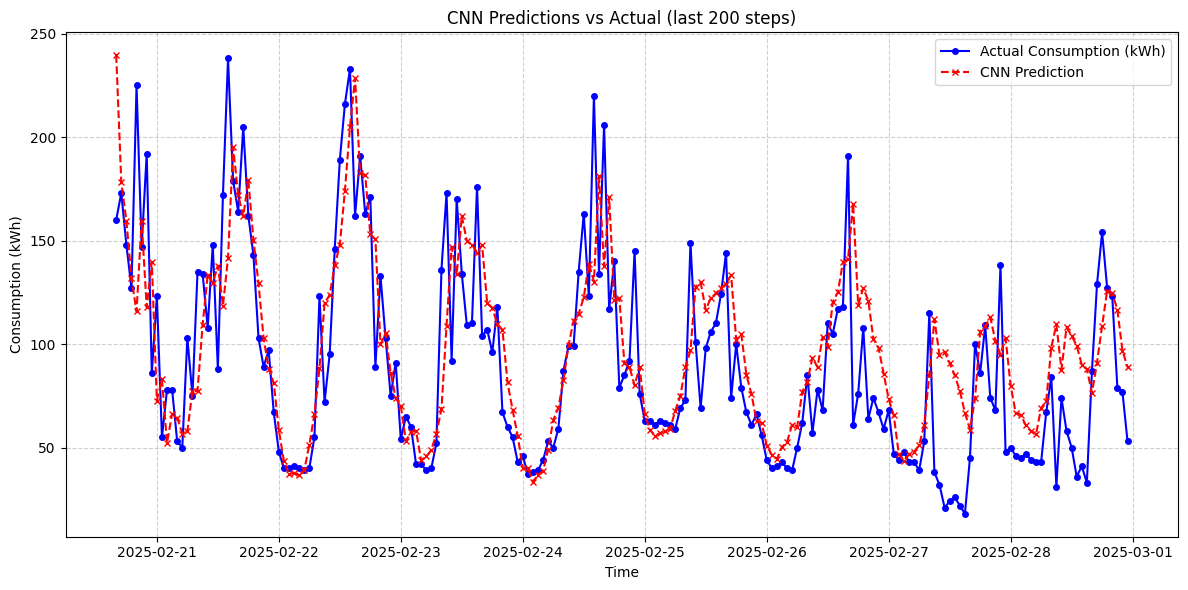

In [ ]:
import matplotlib.pyplot as plt

N = 200  # nombre de points à afficher (zoom sur la fin du test)

plt.figure(figsize=(12, 6))

# Observed values
plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Actual Consumption (kWh)",
    color="blue",
    marker="o",
    markersize=4,
    linestyle="-"
)

# CNN predictions
plt.plot(
    y_test.index[-N:],
    y_test_pred[-N:],
    label="CNN Prediction",
    color="red",
    linestyle="dashed",
    marker="x",
    markersize=4
)

plt.xlabel("Time")
plt.ylabel("Consumption (kWh)")
plt.title(f"CNN Predictions vs Actual (last {N} steps)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# **LSTM (Long Short-Term Memory)**

Long Short-Term Memory networks (LSTMs) have great memories and can remember information which the vanilla RNN is unable to!

Now, this code prepares the dataset for an LSTM model . First, we create **sequences** of length **168** (one week of hourly data) to capture temporal dependencias. Then, the input features are scaled using `MinMaxScaler` to bring all the values on similar range to help the network train more efficiently. These sequences are used as inputs for the **LSTM**, with the corresponding target being the value immediately following each sequence. Finally, the data is split into **training (70%)**, **validation (15%)**, and **test (15%)** sets. To verify that the data is correctly prepared for the **LSTM** input, the shapes of the resulting arrays are printed.

In [52]:
seq_length = 168
def create_sequences(X, y, seq_length=seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq, y_seq = create_sequences(X_scaled, y, seq_length)


split1 = int(len(X_seq) * 0.7)
split2 = int(len(X_seq) * 0.85)
X_train, y_train = X_seq[:split1], y_seq[:split1]
X_val, y_val     = X_seq[split1:split2], y_seq[split1:split2]
X_test, y_test   = X_seq[split2:], y_seq[split2:]

print("Shapes LSTM")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_val   : {X_val.shape}, y_val   : {y_val.shape}")
print(f"X_test  : {X_test.shape}, y_test  : {y_test.shape}")

Shapes LSTM
X_train : (23284, 168, 171), y_train : (23284,)
X_val   : (4990, 168, 171), y_val   : (4990,)
X_test  : (4990, 168, 171), y_test  : (4990,)


After the preprocessing, we are going to implement the **LSTM (Long Short-Term Memory)** network. The model consists of two stacked **LSTM** layers with dropout for regularization, followed by a fully connected layer to produce the final prediction. We compile the network with mean squared error loss and use MAE as an additional metric.

 To ensure stable results, We run the training 10 times, resetting the random seeds each time to get consistent results. During training, **EarlyStopping** and **ReduceLROnPlateau** help prevent overfitting and adjust the learning rate. After each run, we predict on the validation set and calculate **MAE**, **RMSE**, and **R²** to check the model’s performance.

In [ ]:
def lstm_model(input_shape):
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)  # régression
    ])
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    return model

model = lstm_model(input_shape)
model.summary()

# 🔹 5. Reset des seeds
def reset_seeds(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)



# 🔹 6. Entraînement multi-runs
n_runs = 10
results = []
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)



for run in range(n_runs):
    print(f"\n Run {run + 1}")
    seed = 42 + run
    reset_seeds(seed)



    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    y_val_pred = model.predict(X_val, verbose=0).flatten()

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

    results.append({'run': run+1, 'Seed': seed, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 168, 64)        │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,553 (373.25 KB)

 Trainable params: 95,553 (373.25 KB)

 Non-trainable params: 0 (0.00 B)


 Run 1
MAE  : 21.96
RMSE : 30.00
R²   : 0.65

 Run 2
MAE  : 22.03
RMSE : 30.06
R²   : 0.65

 Run 3
MAE  : 22.14
RMSE : 30.02
R²   : 0.65

 Run 4
MAE  : 22.07
RMSE : 30.06
R²   : 0.65

 Run 5
MAE  : 22.07
RMSE : 30.06
R²   : 0.65

 Run 6
MAE  : 22.07
RMSE : 30.06
R²   : 0.65

 Run 7
MAE  : 22.07
RMSE : 30.06
R²   : 0.65

 Run 8
MAE  : 22.07
RMSE : 30.06
R²   : 0.65

 Run 9
MAE  : 22.07
RMSE : 30.06
R²   : 0.65

 Run 10
MAE  : 22.07
RMSE : 30.06
R²   : 0.65


To better understand the results obtained, a dataFrame is created containing the real values `y_test` and predicted ones `y_pred` to see how accurate the model’s predictions to the real ones.

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    # Faire les prédictions
    y_pred = model.predict(X_test, verbose=0).flatten()  # flatten car Keras renvoie (n,1)

    # Affichage des prédictions vs réels
    df_pred = pd.DataFrame({
        'Réel': y_test.values if hasattr(y_test, "values") else y_test,
        'Prédit': y_pred
    })
    print(f"\nActual vs. Predicted Comparison ({model_name}):")
    df_pred.head(10)

    # Retourne les prédictions
    return y_pred


# 🔹 Exemple d’appel après ton entraînement LSTM :
y_pred = evaluate_model(model, X_test, y_test, "LSTM")



Actual vs. Predicted Comparison (LSTM):
   Réel      Prédit
0    45   58.138474
1    43   53.390186
2    42   51.790016
3    42   53.835342
4    43   59.379723
5    62   70.905975
6    63   87.243652
7    77  104.497871
8   185  111.360291
9   197  117.189484


To see how well the **LSTM** model captures the real values, we plot the predicted data against the real (actual) values.

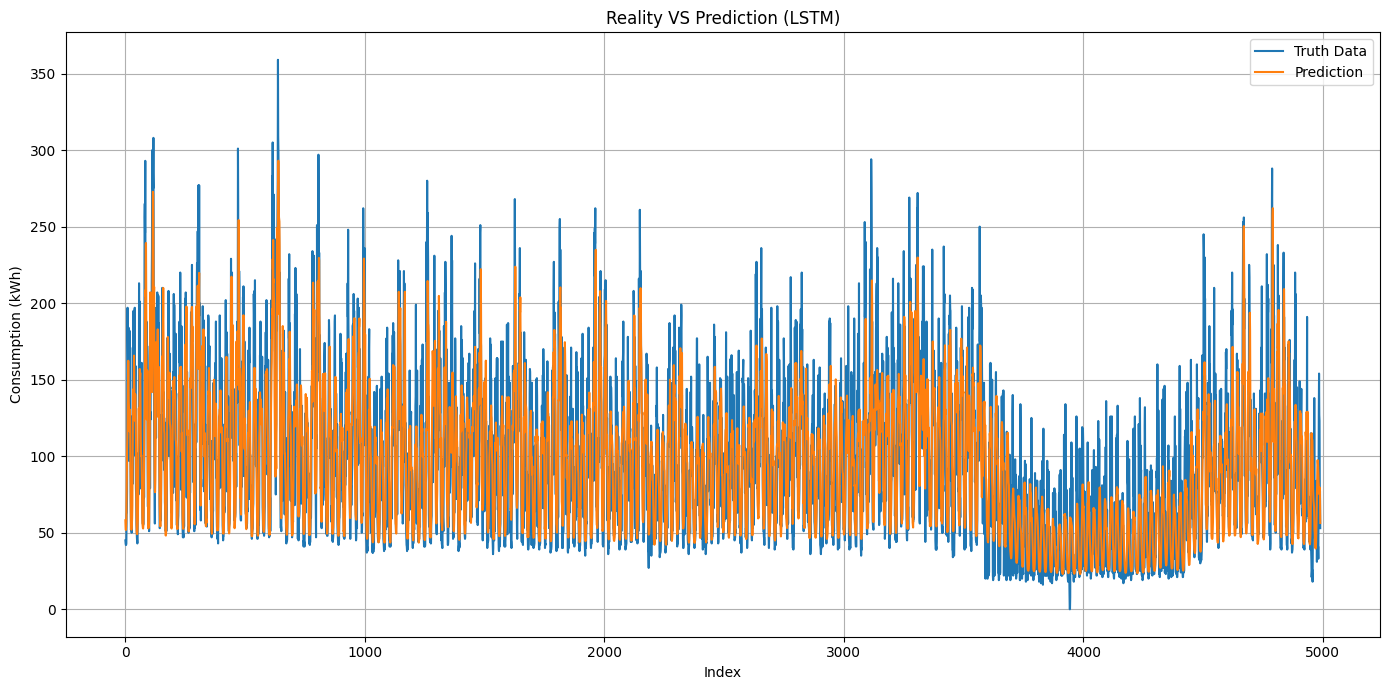

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.values if hasattr(y_test, "values") else y_test, label='Truth Data')
plt.plot(y_pred, label='Prediction')
plt.title("Reality VS Prediction (LSTM)")
plt.xlabel("Index")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **GRU (Gated Recurrent Units)**

The Gated Recurrent Unit (GRU) is the younger sibling of the more popular Long Short-Term Memory (LSTM) network, and belongs to the family of Recurrent Neural Networks (RNNs). Just like its sibling, GRUs are able to effectively retain long-term dependencies in sequential data. And additionally, they can address the “short-term memory” issue plaguing vanilla RNNs.


To ensure robust evaluation, the **GRU** model is trained **10** times with different random seeds. `EarlyStopping` and `ReduceLROnPlateau` are used during training to prevent overfitting and adjust learning rates. After each run, predictions on the validation set are generated, and the metrics are computed to assess the model’s ability to capture electricity consumption patterns.



1 heure d'execution


In [ ]:
def gru_model(input_shape):
    model = models.Sequential([
        layers.GRU(64, return_sequences=True, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.GRU(64),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(1)  # sortie régression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model
model = gru_model(input_shape)
model.summary()
# --- Reset seeds pour reproductibilité ---
def reset_seeds(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

# --- Entraînement multi-runs ---
n_runs = 10
results = []
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)

for run in range(n_runs):
    print(f"\n Run {run + 1}")
    seed = 42 + run
    reset_seeds(seed)

    model = gru_model(input_shape)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # --- Évaluation ---
    y_val_pred = model.predict(X_val, verbose=0).flatten()

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

    results.append({'run': run+1, 'Seed': seed, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 168, 64)        │        45,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 168, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,089 (285.50 KB)

 Trainable params: 72,833 (284.50 KB)

 Non-trainable params: 256 (1.00 KB)


 Run 1
MAE  : 21.93
RMSE : 29.79
R²   : 0.66

 Run 2
MAE  : 22.17
RMSE : 30.03
R²   : 0.65

 Run 3
MAE  : 22.16
RMSE : 29.76
R²   : 0.66

 Run 4
MAE  : 22.31
RMSE : 30.12
R²   : 0.65

 Run 5
MAE  : 22.49
RMSE : 30.43
R²   : 0.64

 Run 6
MAE  : 22.17
RMSE : 30.02
R²   : 0.65

 Run 7
MAE  : 22.02
RMSE : 29.77
R²   : 0.66

 Run 8
MAE  : 21.94
RMSE : 29.75
R²   : 0.66

 Run 9
MAE  : 21.85
RMSE : 29.89
R²   : 0.66

 Run 10
MAE  : 21.96
RMSE : 29.82
R²   : 0.66


To better understand the results obtained, a dataFrame is created containing the real values `y_test` and predicted ones `y_pred` to see how accurate the model’s predictions to the real ones.

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    # Faire les prédictions
    y_pred = model.predict(X_test, verbose=0).flatten()  # flatten car Keras renvoie (n,1)

    # Affichage des prédictions vs réels
    df_pred = pd.DataFrame({
        'Réel': y_test.values if hasattr(y_test, "values") else y_test,
        'Prédit': y_pred
    })
    print(f"\nActual vs. Predicted Comparison ({model_name}):")
    df_pred.head(10)

    # Retourne les prédictions
    return y_pred


# 🔹 Exemple d’appel après ton entraînement LSTM :
y_pred = evaluate_model(model, X_test, y_test, "GRU")



Actual vs. Predicted Comparison (GRU):
   Réel      Prédit
0    45   55.372807
1    43   52.702694
2    42   53.316765
3    42   55.650925
4    43   62.102871
5    62   74.783295
6    63   92.876945
7    77  110.682541
8   185  128.202209
9   197  134.892838


To see how well the **LSTM** model captures the real values, we plot the predicted data against the real (actual) values.

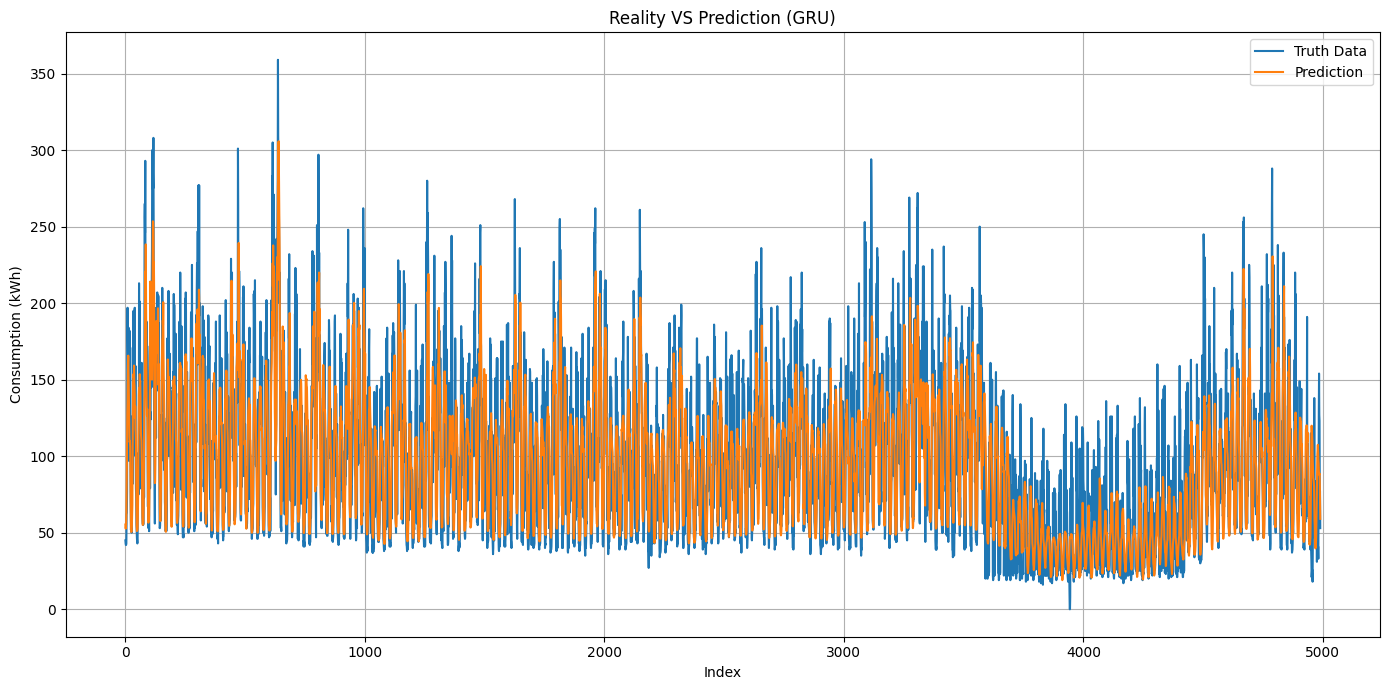

In [ ]:

# --- Visualisation ---
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.values if hasattr(y_test, "values") else y_test, label='Truth Data')
plt.plot(y_pred, label='Prediction')
plt.title("Reality VS Prediction (GRU)")
plt.xlabel("Index")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


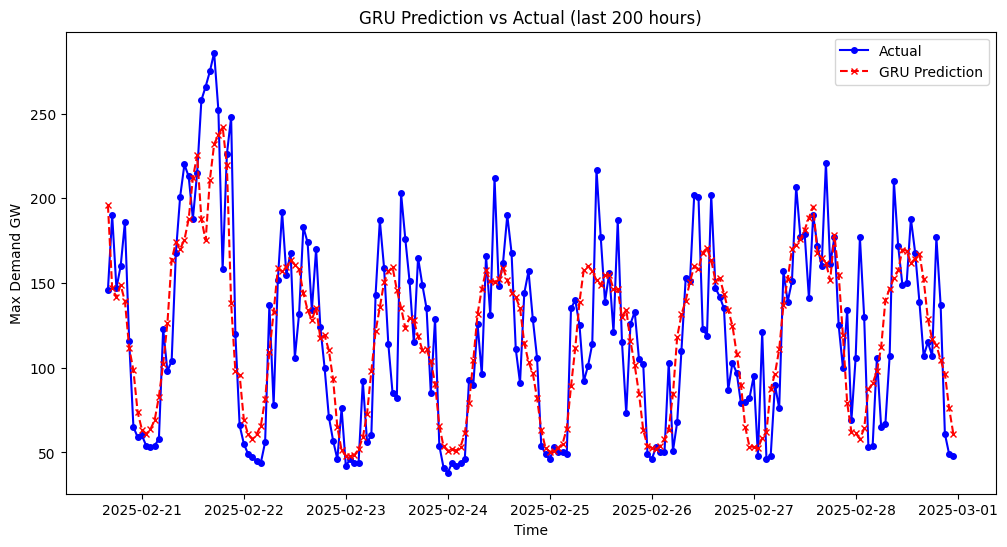

In [ ]:


N = 200

plt.figure(figsize=(12, 6))

plt.plot(
    df.index[-N:],
    y_val[-N:],
    label="Actual",
    color="blue",
    marker="o",
    markersize=4,
    linestyle="-"
)

plt.plot(
    df.index[-N:],
    y_val_pred_gru[-N:],
    label="GRU Prediction",
    color="red",
    linestyle="dashed",
    marker="x",
    markersize=4
)

plt.xlabel("Time")
plt.ylabel("consumption")
plt.title(f"GRU Prediction vs Actual (last {N} hours)")
plt.legend()
plt.show()


# **TCN (Temporal Convolutional Networks)**

A **Temporal Convolutional Network (TCN)** is a deep learning architecture designed for sequence modeling. **TCNs** use causal and dilated convolutions to capture both short-term and long-term dependencies in time series data, while preserving the temporal order. They are often more stable and faster to train than recurrent networks like LSTMs or GRUs.

For more details, see: https://arxiv.org/abs/1803.01271?




The model is implemented as a `Sequential Keras model` with the following components:



1.   **TCN Layer:**



*   This is the core of the model. The TCN layer uses causal convolutions, meaning that at each time step, the network only sees current and past values, never future ones.

*   Dilated convolutions are applied with dilation rates `[1, 2, 4, 8]`, which allows the network to cover a larger temporal range without increasing the number of layers.

*   `nb_filters=64 ` specifies that `64 convolutional ` filters are used to extract features at each time step.

*   `kernel_size=3` defines the width of the convolutional window.

*   `dropout_rate=0.3` helps prevent overfitting by randomly ignoring **30%** of the connections during training.

*   The output of this layer encodes temporal patterns from the input sequence, both local (recent time steps) and long-term trends.



2.   **Fully Connected Dense Layer (32 units, ReLU):** Combines extracted features and adds non-linearity to capture complex temporal patterns.

3.  **Dropout Layer (0.3):** Prevents overfitting by randomly dropping 30% of activations during training.

4.  **Output Layer (1 unit):** Produces the predicted electricity consumption for the next time step.


In [ ]:
def tcn_model(input_shape):
    model = models.Sequential([
        TCN(input_shape=input_shape, nb_filters=64, kernel_size=3, nb_stacks=1, dilations=[1, 2, 4, 8],
            dropout_rate=0.3, return_sequences=False, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1)  # sortie régression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_24 (GRU)                    │ (None, 168, 64)        │        45,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 168, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,757 (854.52 KB)

 Trainable params: 72,833 (284.50 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 145,668 (569.02 KB)

Now, we train the model 10 times, calculating the performance metrics (MAE, RMSE, R²) after each run to assess its stability and accuracy.

In [ ]:
# --- Reset seeds pour reproductibilité ---
def reset_seeds(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

# --- Entraînement multi-runs ---
n_runs = 10
results = []
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)

for run in range(n_runs):
    print(f"\n Run {run + 1}")
    seed = 42 + run
    reset_seeds(seed)

    model = tcn_model(input_shape)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # --- Évaluation ---
    y_val_pred = model.predict(X_val, verbose=0).flatten()

    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

    results.append({'run': run+1, 'Seed': seed, 'MAE': mae, 'RMSE': rmse, 'R2': r2})


 Run 1
MAE  : 22.18
RMSE : 30.36
R²   : 0.65

 Run 2
MAE  : 22.08
RMSE : 30.05
R²   : 0.65

 Run 3
MAE  : 22.38
RMSE : 30.87
R²   : 0.63

 Run 4
MAE  : 22.26
RMSE : 30.49
R²   : 0.64

 Run 5
MAE  : 21.93
RMSE : 30.06
R²   : 0.65

 Run 6
MAE  : 21.97
RMSE : 30.24
R²   : 0.65

 Run 7
MAE  : 22.23
RMSE : 29.92
R²   : 0.66

 Run 8
MAE  : 21.88
RMSE : 30.29
R²   : 0.65

 Run 9
MAE  : 22.11
RMSE : 30.21
R²   : 0.65

 Run 10
MAE  : 22.12
RMSE : 30.29
R²   : 0.65


To better understand the results obtained, a dataFrame is created containing the real values `y_test` and predicted ones `y_pred` to see how accurate the model’s predictions to the real ones.

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):

    y_val_pred = model.predict(X_test, verbose=0).flatten()


    df_pred = pd.DataFrame({
        'Réel': y_test.values if hasattr(y_test, "values") else y_test,
        'Prédit': y_pred
    })
    print(f"\nActual vs. Predicted Comparison ({model_name}):")
    df_pred.head(10)
    return y_pred

y_val_pred = evaluate_model(model, X_test, y_test, "TCN")



Actual vs. Predicted Comparison (TCN):
   Réel      Prédit
0    45   49.121071
1    43   48.014175
2    42   50.308861
3    42   45.820312
4    43   44.755333
5    62   56.330223
6    63   74.168365
7    77  110.323608
8   185  115.313538
9   197  123.653488


To see how well the **TCN** model captures the real values, we plot the predicted data against the real (actual) values.

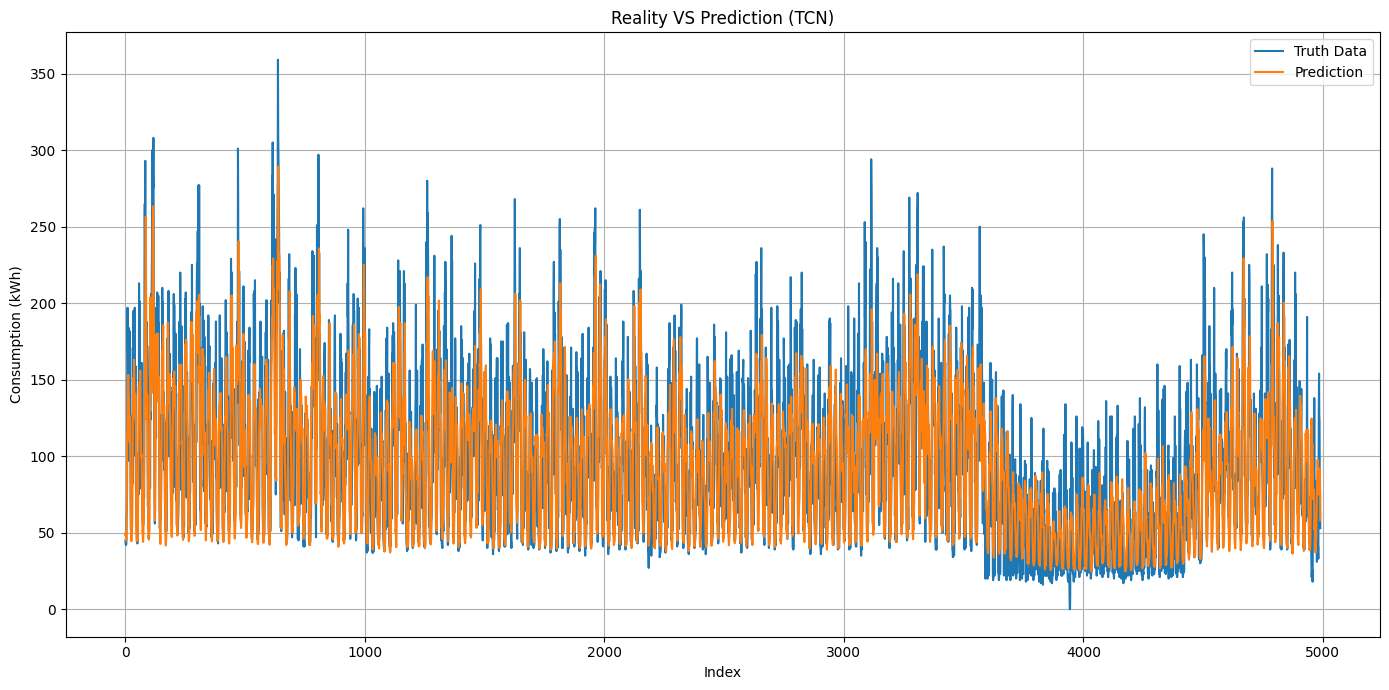

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.values if hasattr(y_test, "values") else y_test, label='Truth Data')
plt.plot(y_pred, label='Prediction')
plt.title("Reality VS Prediction (TCN)")
plt.xlabel("Index")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



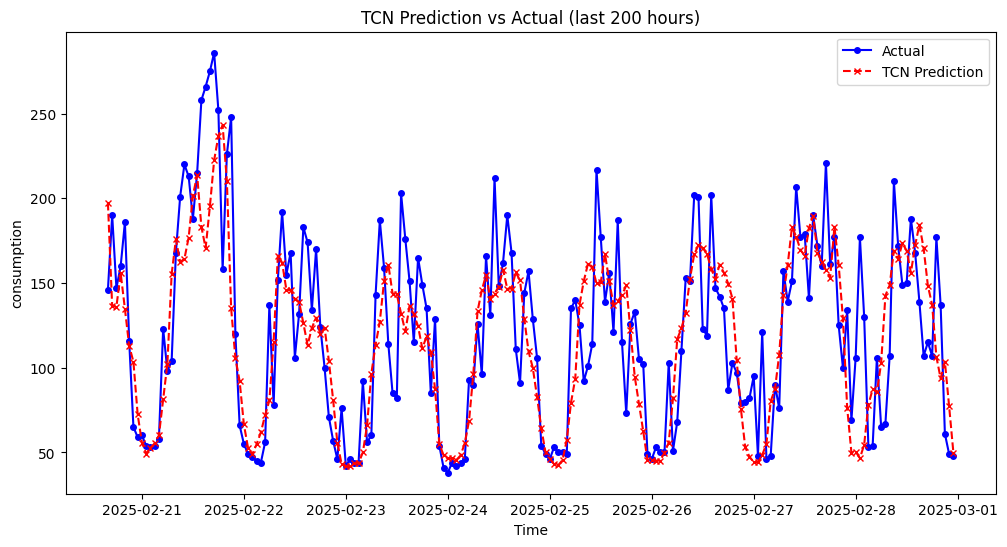

In [ ]:
import matplotlib.pyplot as plt

N = 200  # nombre de points à afficher (tu peux changer)

plt.figure(figsize=(12, 6))

plt.plot(
    df.index[-N:],
    y_val[-N:],
    label="Actual",
    color="blue",
    marker="o",
    markersize=4,
    linestyle="-"
)

plt.plot(
    df.index[-N:],
    y_val_pred[-N:],
    label="TCN Prediction",
    color="red",
    linestyle="dashed",
    marker="x",
    markersize=4
)

plt.xlabel("Time")
plt.ylabel("consumption")
plt.title(f"TCN Prediction vs Actual (last {N} hours)")
plt.legend()
plt.show()



# **Comparaison section**

SARIMAX vs

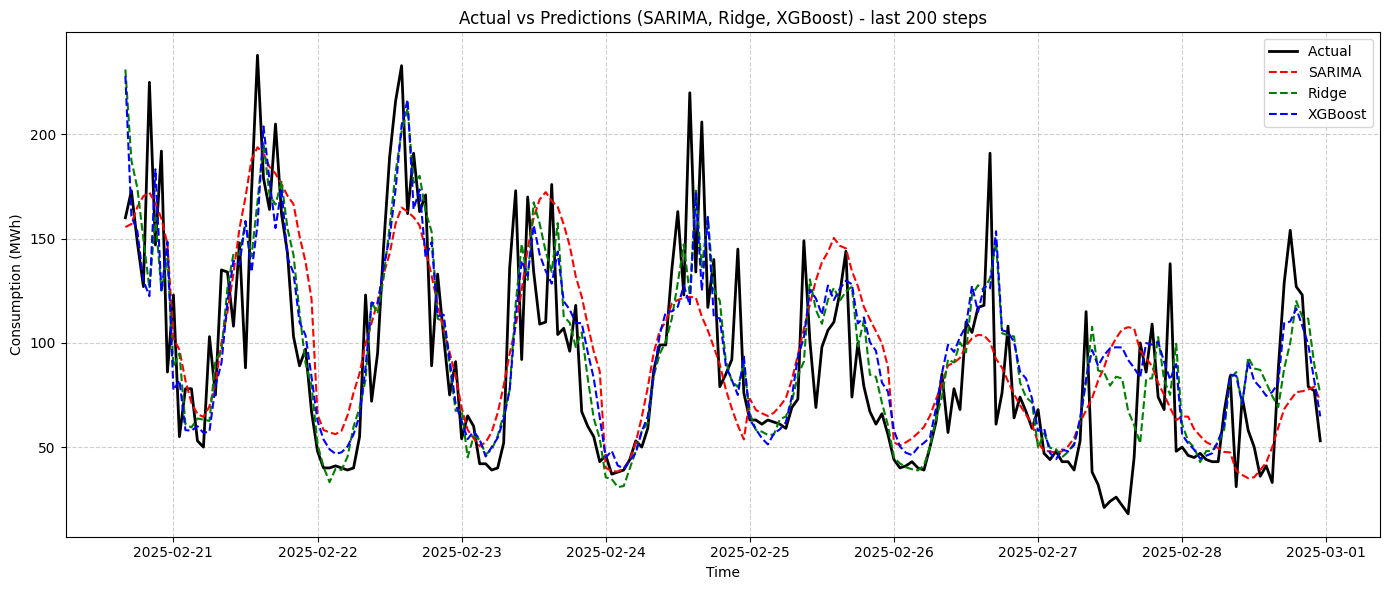

In [51]:
import matplotlib.pyplot as plt

N = 200

plt.figure(figsize=(14, 6))


plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Actual ",
    color="black",
    linestyle="-",
    linewidth=2
)

# SARIMA predictions
plt.plot(
    y_test.index[-N:],
    predicciones_test[-N:],
    label="SARIMA",
    color="red",
    linestyle="--"
)

# Ridge predictions
plt.plot(
    y_test.index[-N:],
    y_pred_ridge[-N:],
    label="Ridge",
    color="green",
    linestyle="--"
)

# XGBoost predictions
plt.plot(
    y_test.index[-N:],
    y_pred_xgb[-N:],
    label="XGBoost",
    color="blue",
    linestyle="--"
)

plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.title(f"Actual vs Predictions (SARIMA, Ridge, XGBoost) - last {N} steps")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


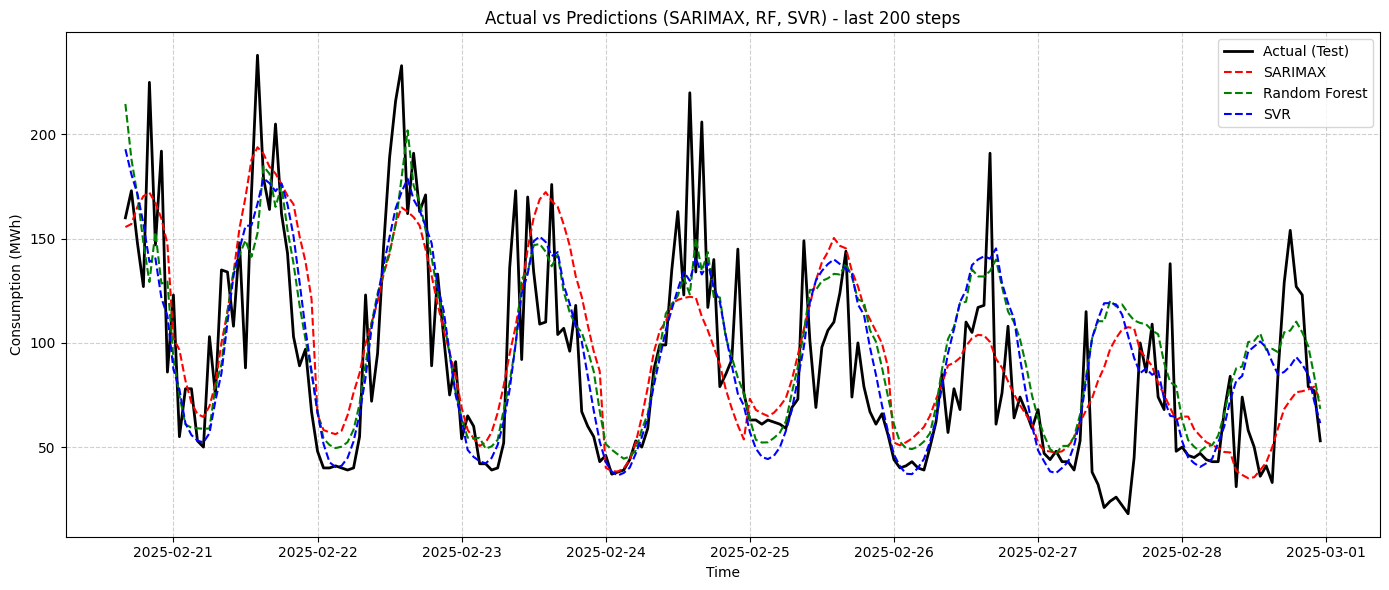

In [ ]:
import matplotlib.pyplot as plt

N = 200

plt.figure(figsize=(14, 6))


plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Actual (Test)",
    color="black",
    linestyle="-",
    linewidth=2
)

# SARIMAX predictions
plt.plot(
    y_test.index[-N:],
    predicciones_test[-N:],
    label="SARIMAX",
    color="red",
    linestyle="--"
)

# Random Forest predictions
plt.plot(
    y_test.index[-N:],
    y_pred_rf[-N:],
    label="Random Forest",
    color="green",
    linestyle="--"
)

# SVR predictions
plt.plot(
    y_test.index[-N:],
    y_pred_svr[-N:],
    label="SVR",
    color="blue",
    linestyle="--"
)

plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.title(f"Actual vs Predictions (SARIMAX, RF, SVR) - last {N} steps")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


CNN VS SARIMA

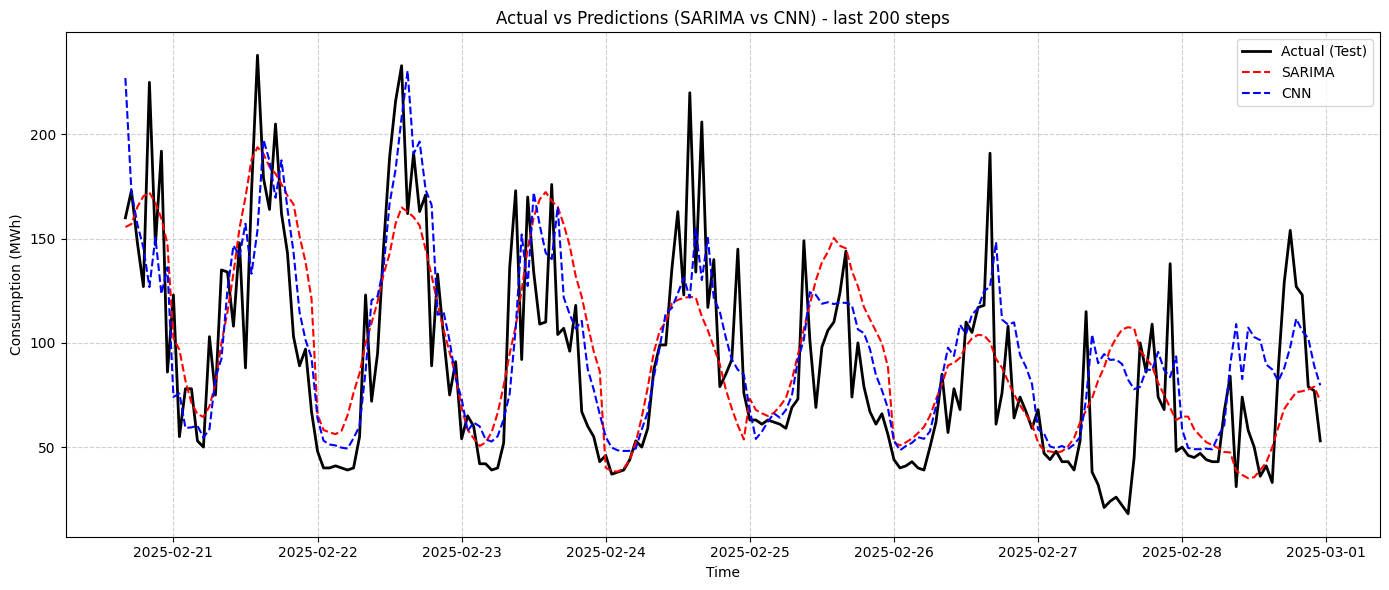

In [46]:
N = 200

plt.figure(figsize=(14, 6))

plt.plot(
    y_test.index[-N:],
    y_test.values[-N:],
    label="Actual (Test)",
    color="black",
    linestyle="-",
    linewidth=2
)

# SARIMA predictions
plt.plot(
    y_test.index[-N:],
    predicciones_test[-N:],
    label="SARIMA",
    color="red",
    linestyle="--"
)

# CNN predictions
plt.plot(
    y_test.index[-N:],
    y_test_pred[-N:],
    label="CNN",
    color="blue",
    linestyle="--"
)

plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.title(f"Actual vs Predictions (SARIMA vs CNN) - last {N} steps")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()